## AIM: Train & tune Graph Convulation Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

GraphLambda with & without edge attributes for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (l/m/r; frontal, central, posterior) and connectivity features per frequency band per channel group (l/m/r; frontal, central, posterior). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

Have to use features before feature selection, to maintain even dimensions for each graph.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [17]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [19]:
# import stat & conn features without feature selection
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 1218)


ID  diagnosis  epoch  EO_l_frontal_delta_std  \
1287  sub-88035721          2      4                0.321143   
1267  sub-88033201          2      8                0.364136   
2269  sub-88065021          0      2                0.399488   

      EO_l_frontal_delta_mean  EO_l_frontal_delta_median  \
1287                -0.115895                  -0.116927   
1267                -0.149581                  -0.139319   
2269                -0.159811                  -0.155493   

      EO_l_frontal_delta_skew  EO_l_frontal_delta_kurt  \
1287                -0.155419                 0.218370   
1267                -0.134998                -0.088306   
2269                -0.633843                 0.918040   

      EO_m_frontal_delta_std  EO_m_frontal_delta_mean  ...  \
1287                0.333796                -0.123434  ...   
1267                0.354067                -0.149085  ...   
2269                0.331942                -0.123886  ...   

      ratio_gamma_m_central-r_central  ratio_gamma_m_central-l_posterior  \
1287                         1.014407                           0.996839   
1267                         0.968461                           1.011588   
2269                         1.029608                           1.047203   

      ratio_gamma_m_central-m_posterior  ratio_gamma_m_central-r_posterior  \
1287                           1.018766                           1.002625   
1267                           1.017839                           1.011591   
2269                           1.041583                           1.044390   

      ratio_gamma_r_central-l_posterior  ratio_gamma_r_central-m_posterior  \
1287                           1.009185                           1.017697   
1267                           1.011516                           1.015242   
2269                           1.061238                           1.035763   

      ratio_gamma_r_central-r_posterior  ratio_gamma_l_posterior-m_posterior  \
1287                           1.011151                             1.019762   
1267                           1.025957                             0.987592   
2269                           1.035241                             1.027661   

      ratio_gamma_l_posterior-r_posterior  ratio_gamma_m_posterior-r_posterior  
1287                             1.018526                             1.020593  
1267                             0.980523                             0.986124  
2269                             1.047181                             1.027831  

[3 rows x 1218 columns]

In [20]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [21]:
synchrony_feature_dict = load_file(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [22]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


C:\Users\tuur\AppData\Local\Temp\ipykernel_25428\1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [23]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'skew', 'kurt'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [24]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')



















100%|██████████| 224/224 [00:25<00:00,  8.92it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [25]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')



















100%|██████████| 225/225 [00:06<00:00, 34.12it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [26]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

# process_subject(subjects_ratio_syncro_matrices[0], subjects_ratio_ids[0])

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')



















100%|██████████| 224/224 [00:07<00:00, 28.96it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


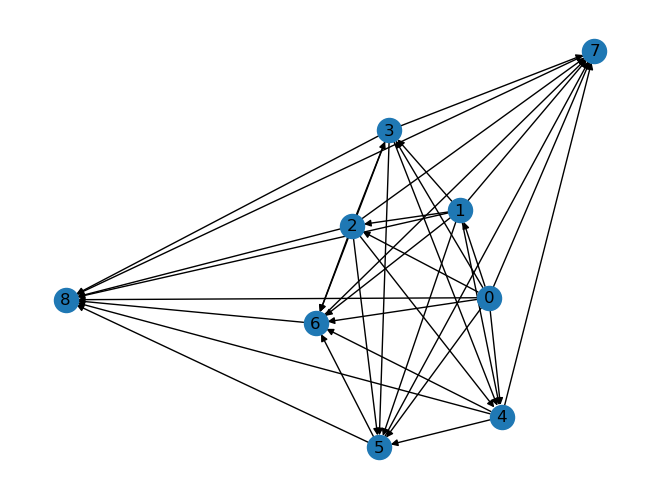

In [27]:
nx.draw(to_networkx(ratio_graph_dataset[0]), with_labels=True)

In [28]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# GCN models:

### Model: graphLambda without edge_attr

In [29]:
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class graphLambda_wo_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_wo_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATConv(n_features, 256, heads=3)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATConv(256*3, 128, heads=3)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATConv(128*3, 128, heads=3)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for fc, dropout in zip(self.fcs, self.dropouts):
            cr = F.relu(fc(cr))
            cr = dropout(cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        return y_hat

### Model: graphLambda with edge_attr

In [30]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv, GATv2Conv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC
n_edge_attrs = 5 # [Delta, Theta, Alpha, Beta, Gamma]

class graphLambda_w_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_w_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATv2Conv(n_features, 256, heads=3, edge_dim=n_edge_attrs)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATv2Conv(256*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATv2Conv(128*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index, edge_attr))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index, edge_attr))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index, edge_attr))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for fc, dropout in zip(self.fcs, self.dropouts):
            cr = F.relu(fc(cr))
            cr = dropout(cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        return y_hat

# 1. EC feature set

In [31]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ec_y_list[i] for i in baseline_rest_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


### Model: graphLambda without edge_attr

In [32]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    # fc_layers = 1
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    # n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=1)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_wo_edge_attrs_trials.pkl')

[I 2024-05-22 15:55:55,619] A new study created in memory with name: no-name-69f9bd9b-4c26-4a4e-8e83-ee0d30dd60cf


Tested parameters: {'learning_rate': 0.004237845443364981, 'optimizer_name': 'Adam', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.3721577893515982}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:58:49,497] Trial 0 finished with value: 0.06666667014360428 and parameters: {'learning_rate': 0.004237845443364981, 'optimizer': 'Adam', 'batch_size': 680, 'fc_layers': 2, 'dropout': 0.3721577893515982}. Best is trial 0 with value: 0.06666667014360428.


Best trial:
  Value: 0.06666667014360428
  Params: 
    learning_rate: 0.004237845443364981
    optimizer: Adam
    batch_size: 680
    fc_layers: 2
    dropout: 0.3721577893515982


In [165]:
df_trials = pd.read_pickle('ec_results_wo_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.229572 2024-05-22 14:59:21.200469 2024-05-22 15:05:18.221093   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:05:57.020624                170          0.2492                 1   

   params_learning_rate params_optimizer     state  
0              0.001392              SGD  COMPLETE

#### Visualizations

In [85]:
# function to change axes size
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

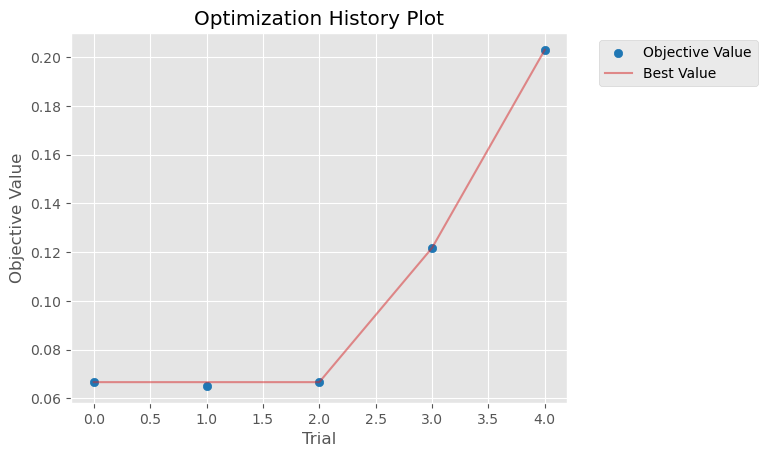

In [86]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


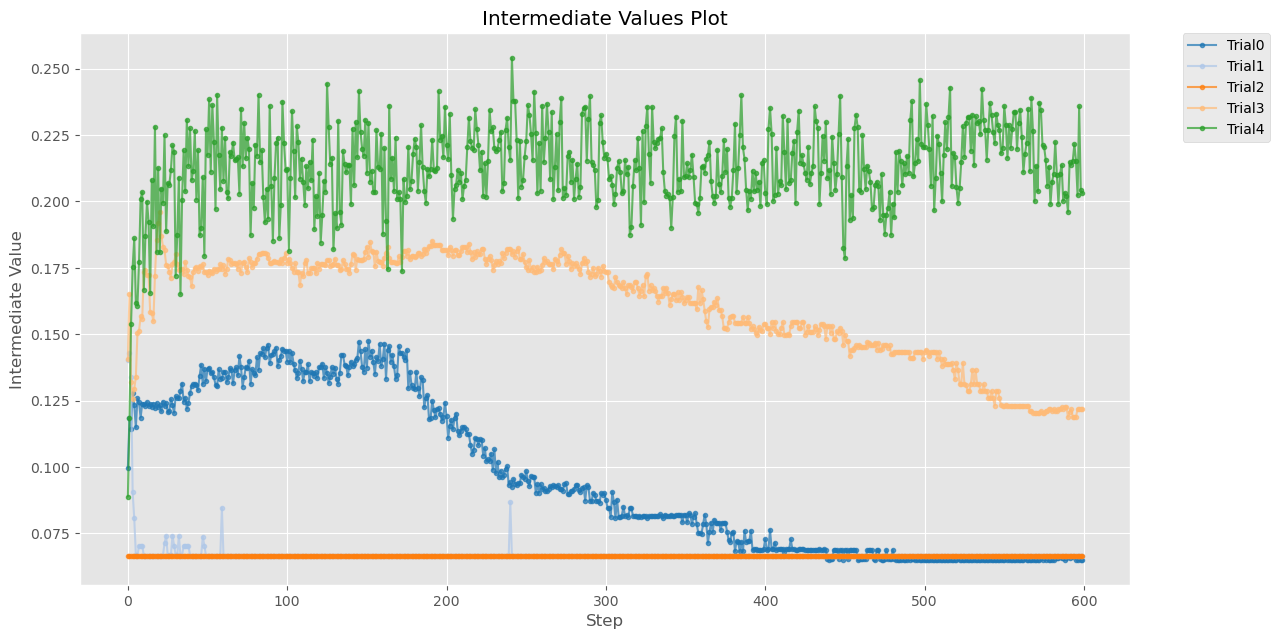

In [87]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


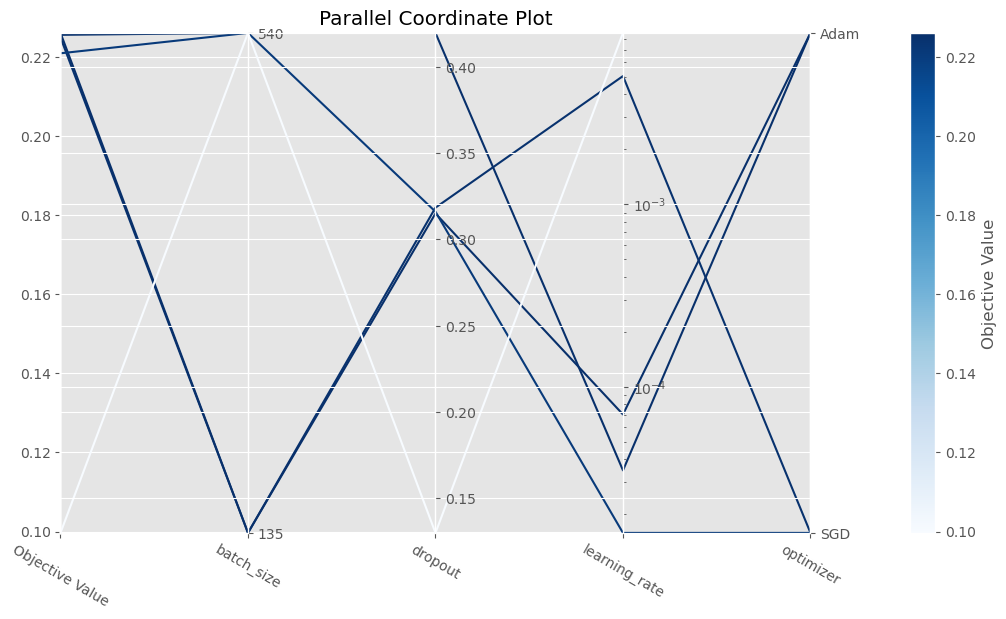

In [74]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


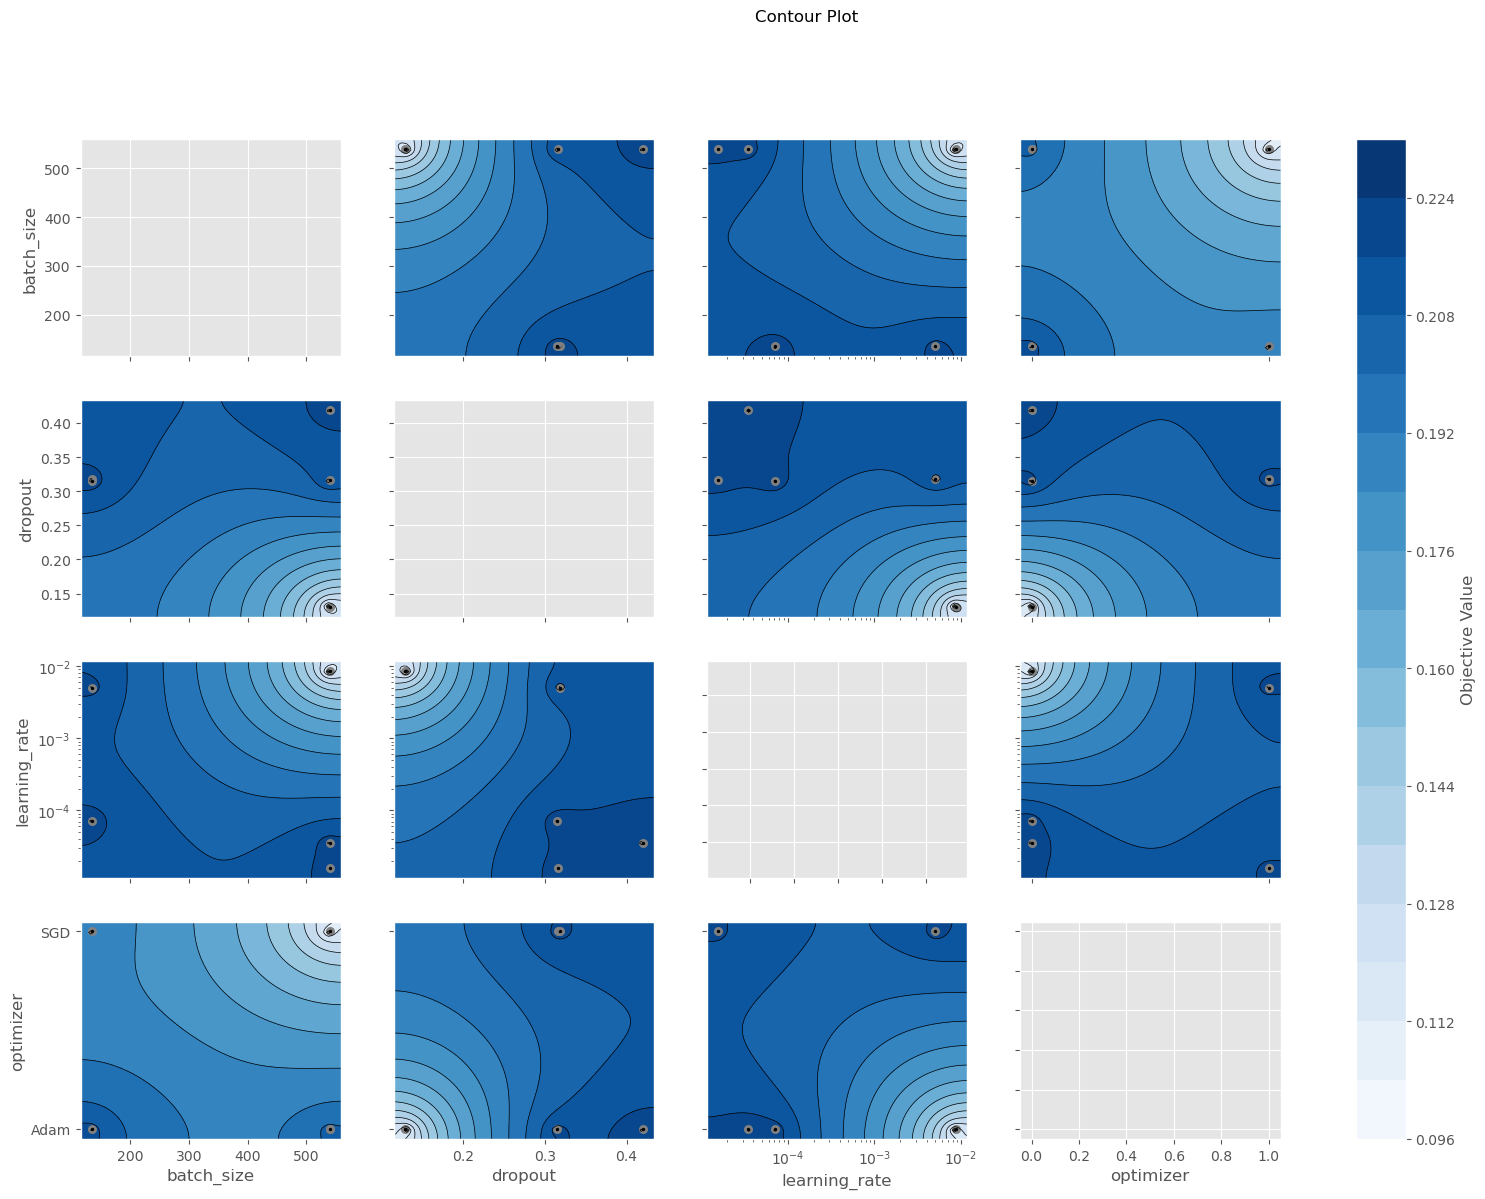

In [75]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

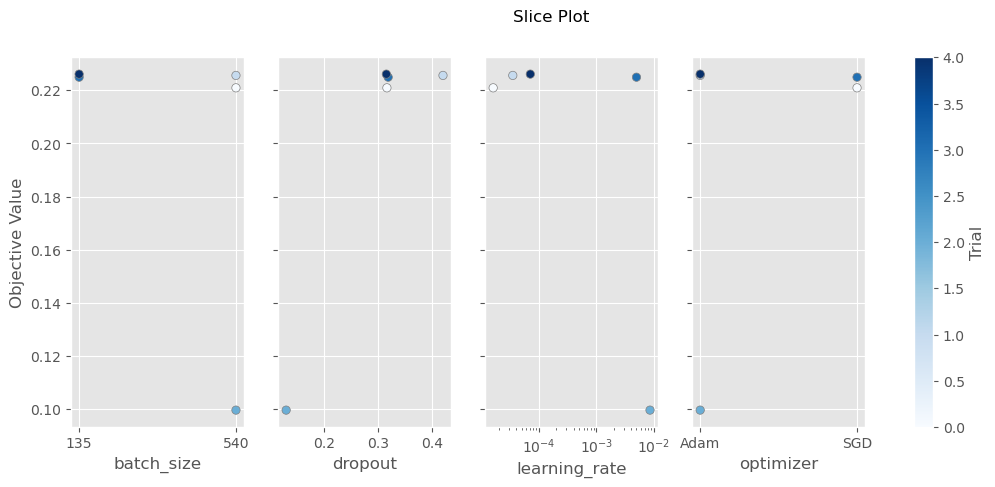

In [76]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

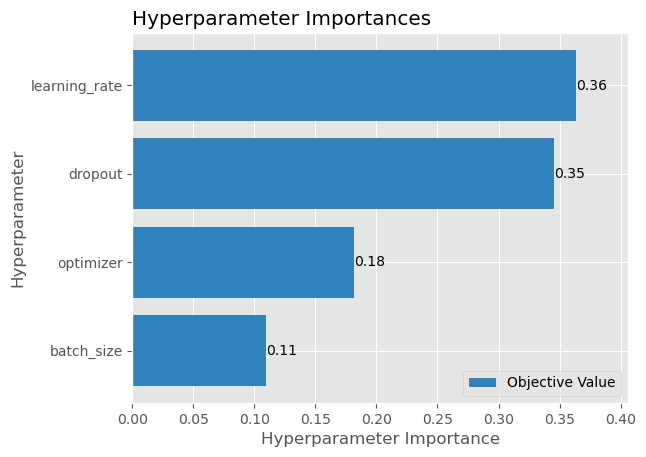

In [77]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

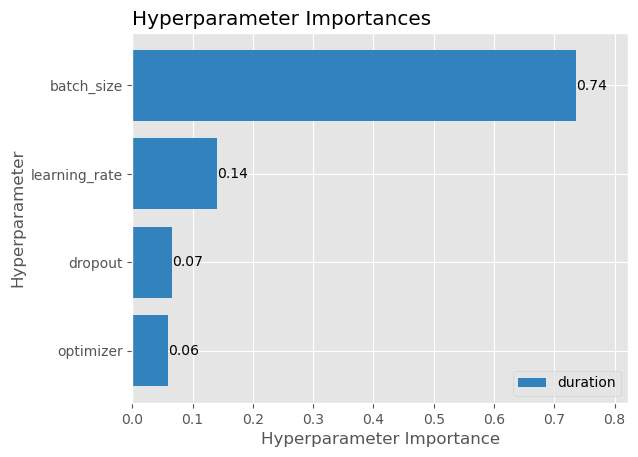

In [78]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

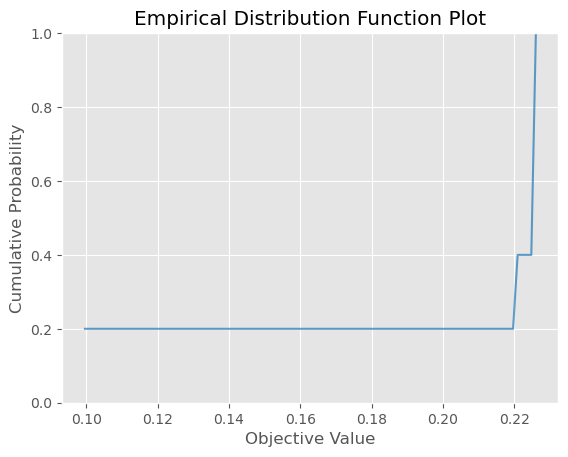

In [79]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


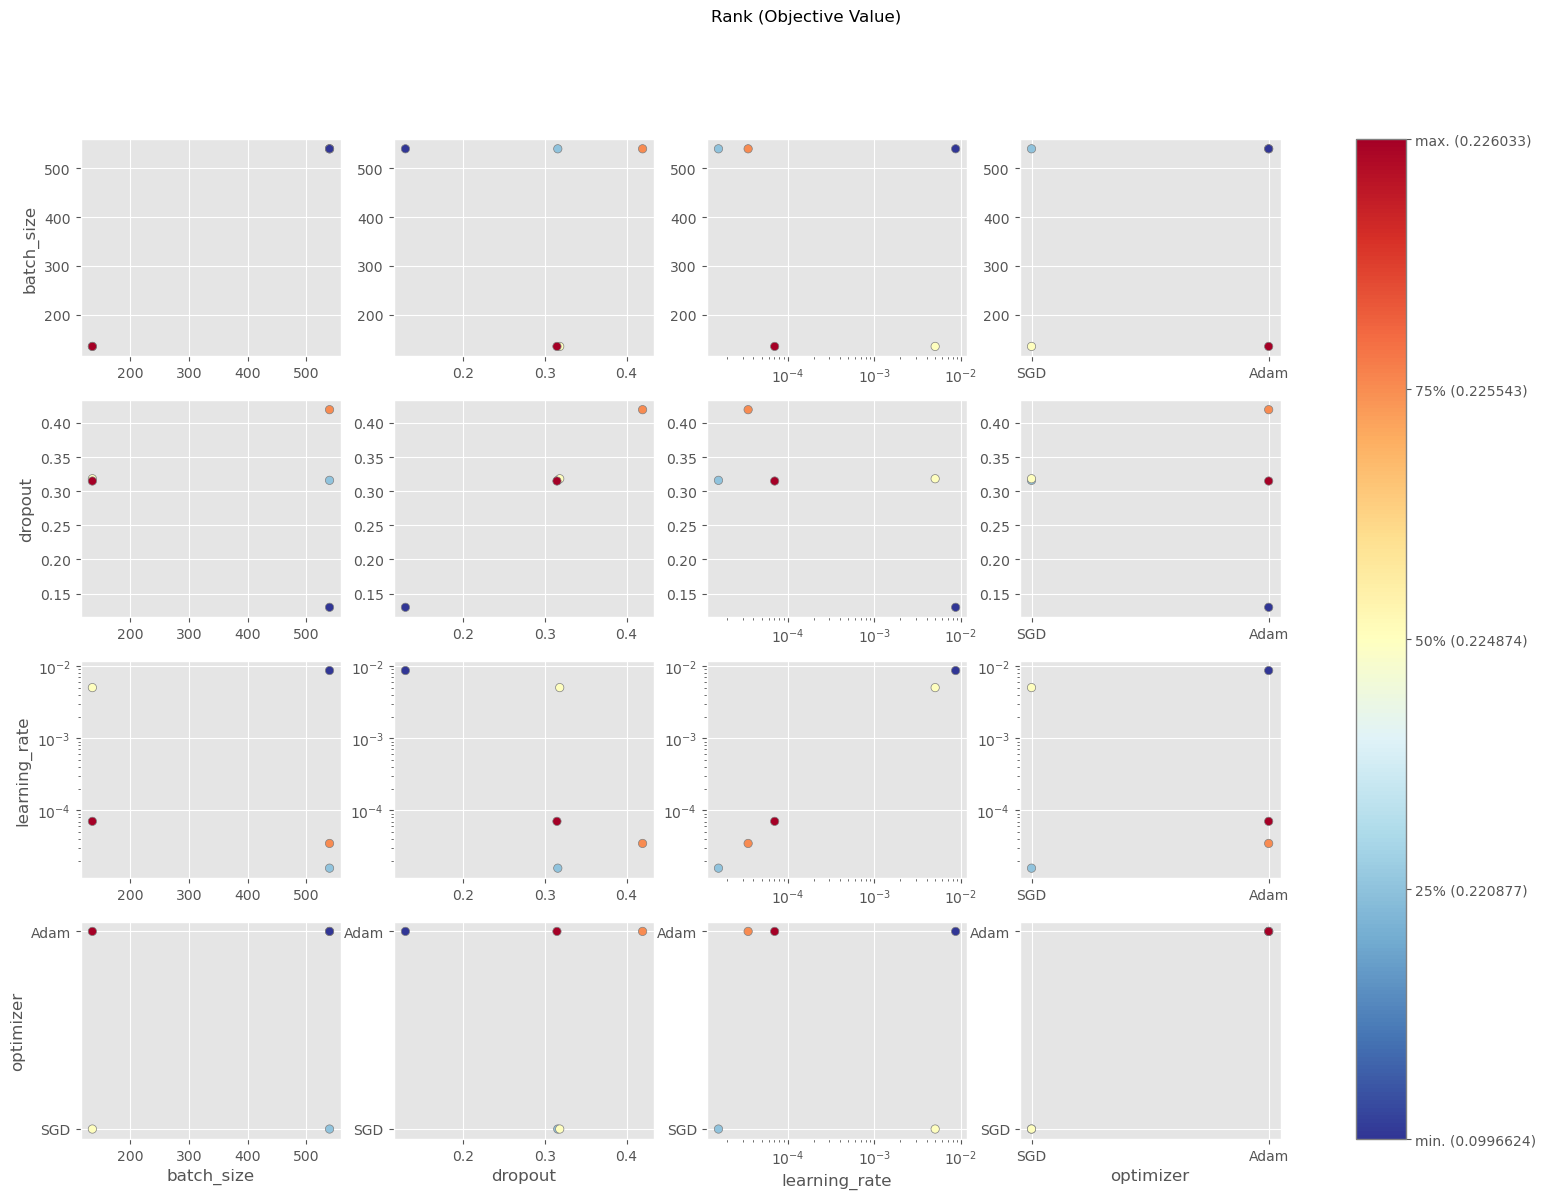

In [80]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


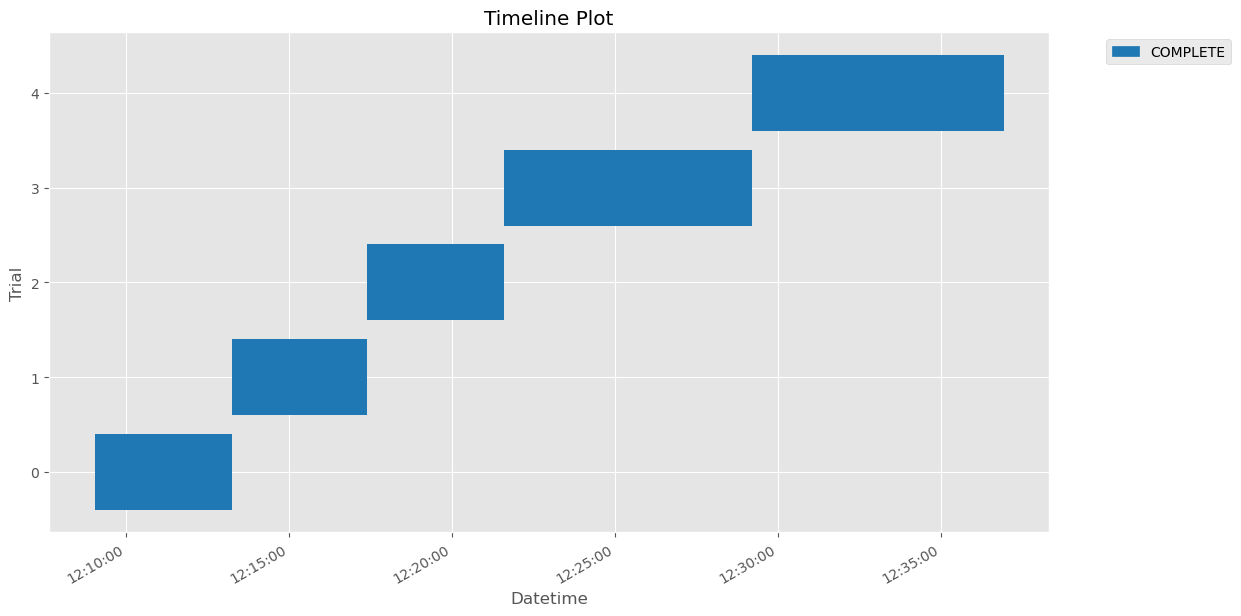

In [81]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

### Model: graphLambda with edge_attr

In [166]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    # fc_layers = 1
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')


    # Create the model
    model = graphLambda_w_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_w_edge_attrs_trials.pkl')

[I 2024-05-22 15:05:18,399] A new study created in memory with name: no-name-41a6fff4-951c-4502-aaf8-d331c23c6aea


Tested parameters: {'learning_rate': 0.0005812784649518039, 'optimizer_name': 'Adam', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.625762720905019}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:10:28,859] Trial 0 finished with value: 0.06666667014360428 and parameters: {'learning_rate': 0.0005812784649518039, 'optimizer': 'Adam', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.625762720905019}. Best is trial 0 with value: 0.06666667014360428.


Best trial:
  Value: 0.06666667014360428
  Params: 
    learning_rate: 0.0005812784649518039
    optimizer: Adam
    batch_size: 340
    fc_layers: 4
    dropout: 0.625762720905019


In [167]:
df_trials = pd.read_pickle('ec_results_w_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.066667 2024-05-22 15:05:18.401801 2024-05-22 15:10:28.857848   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:05:10.456047                340        0.625763                 4   

   params_learning_rate params_optimizer     state  
0              0.000581             Adam  COMPLETE

#### Visualizations

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

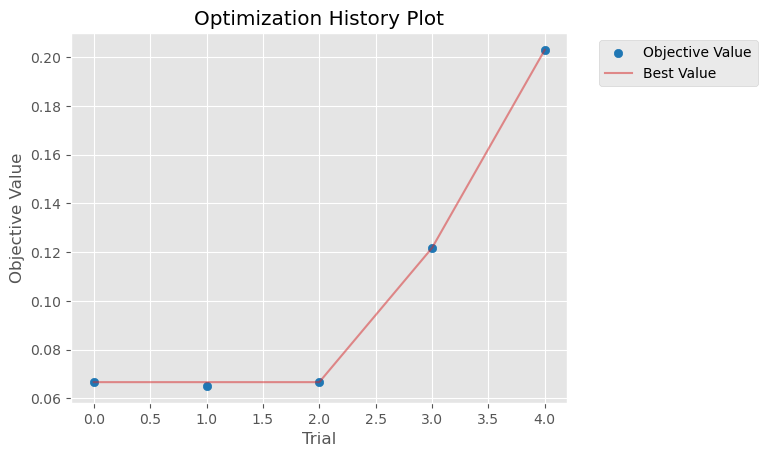

In [ ]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


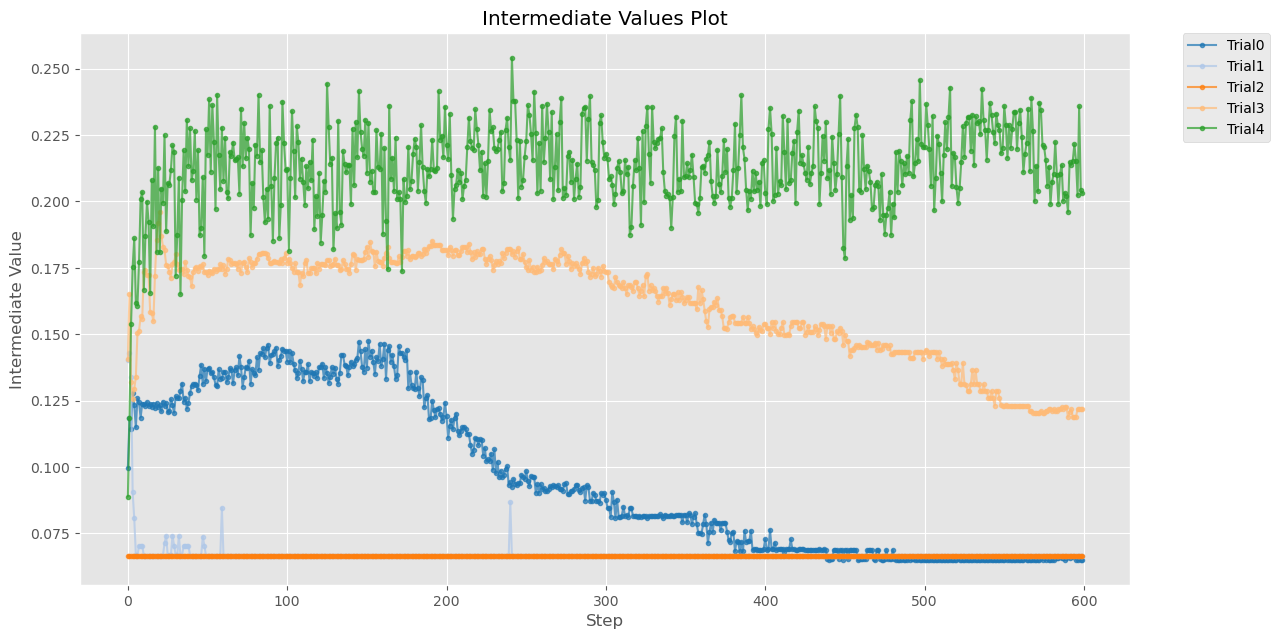

In [ ]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


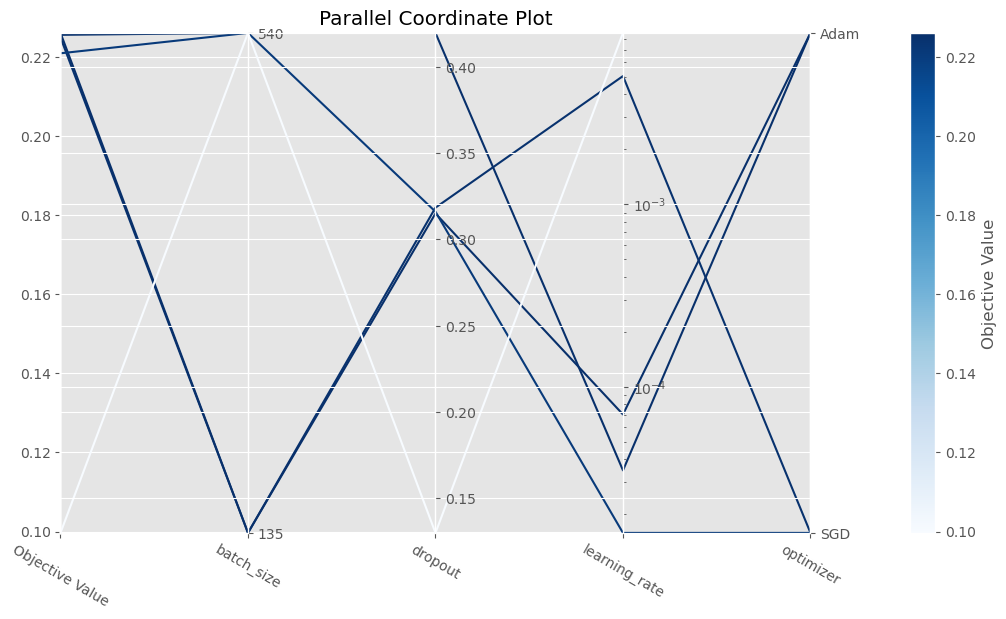

In [ ]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


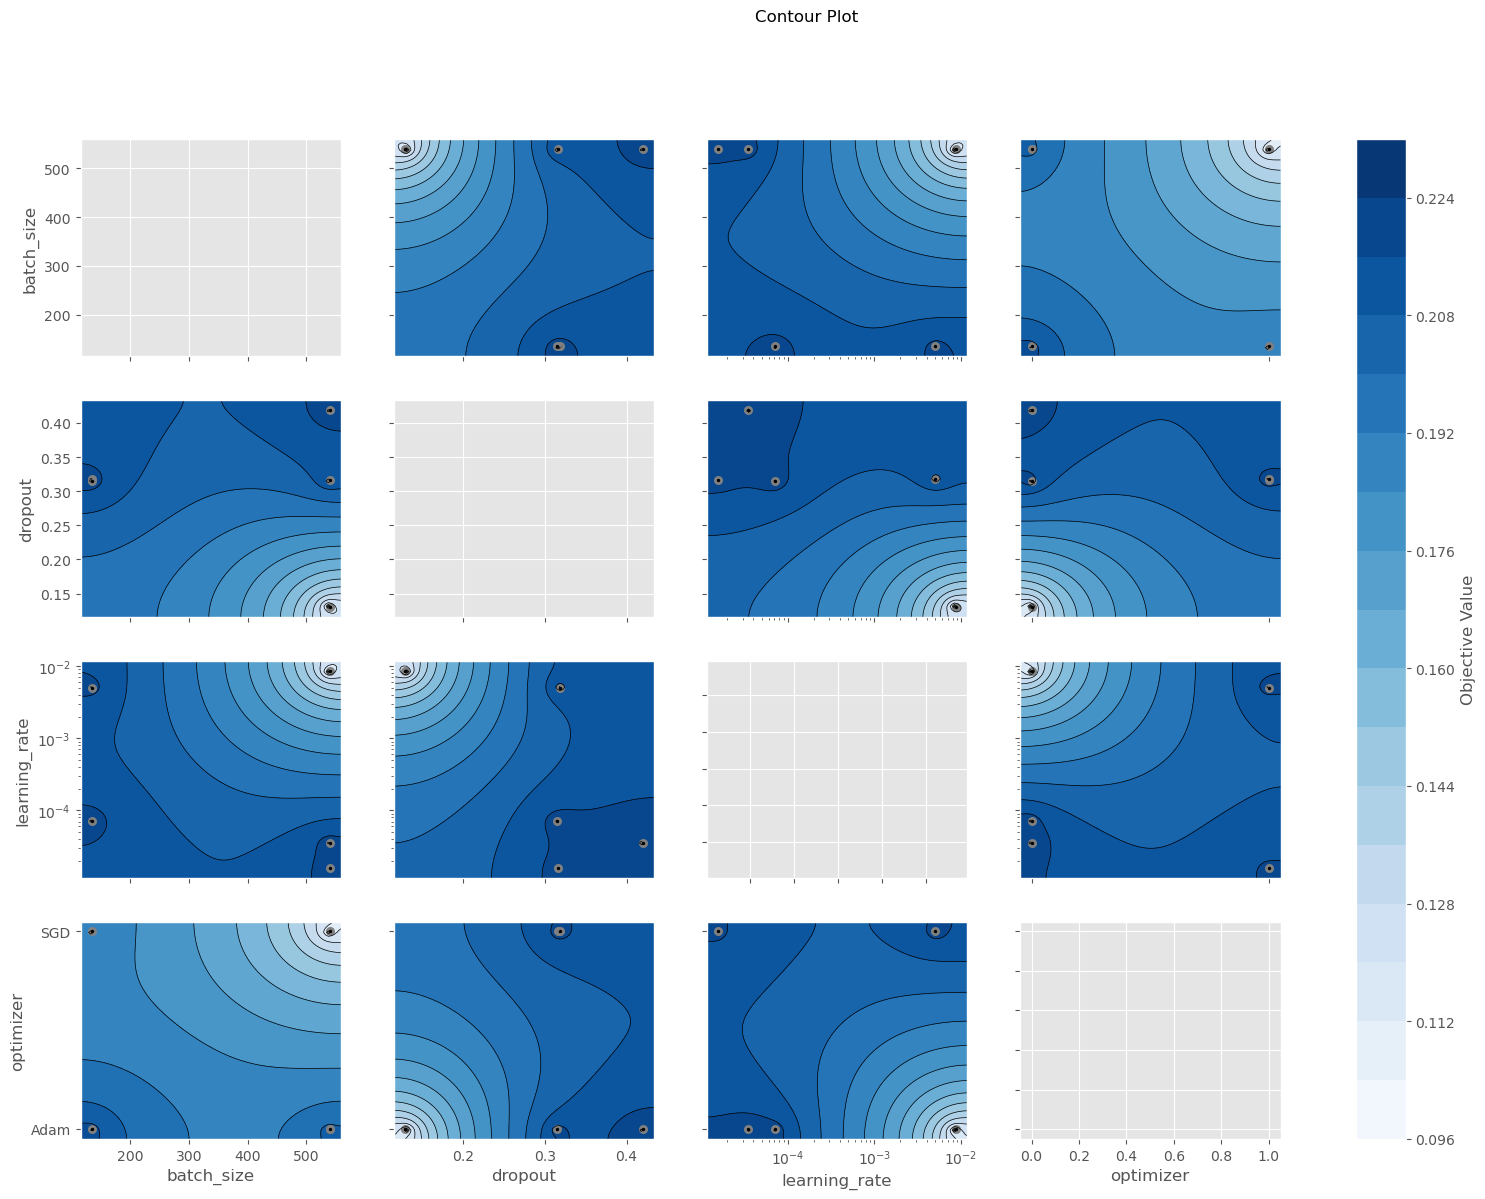

In [ ]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

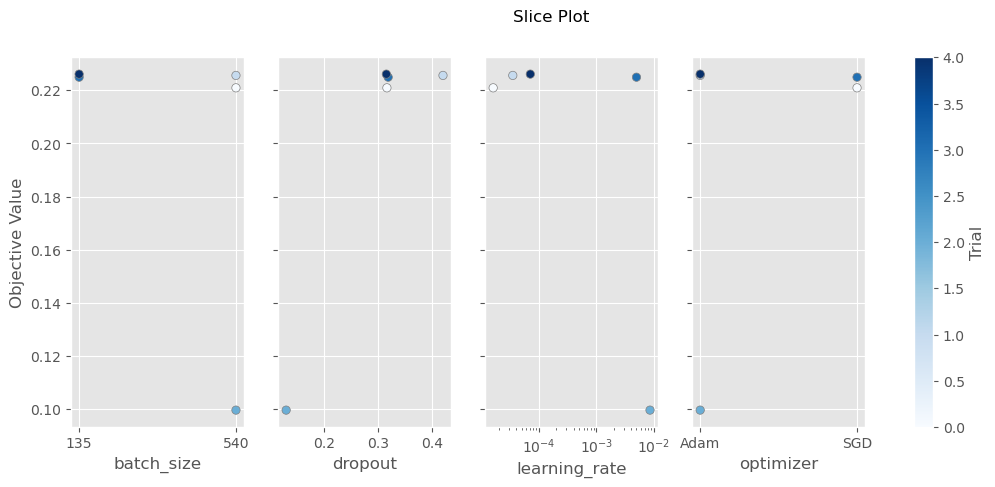

In [ ]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

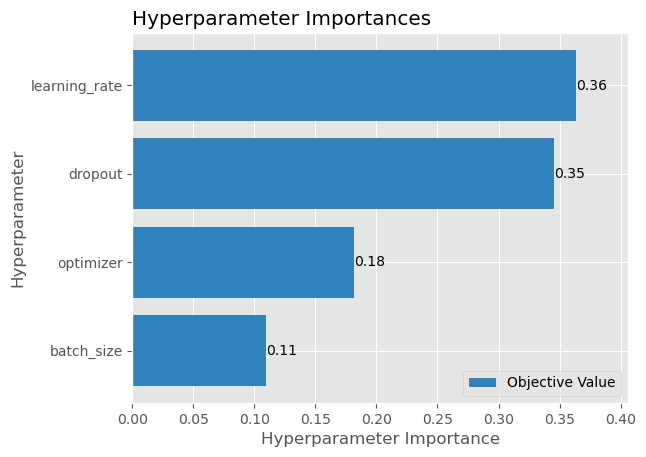

In [ ]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

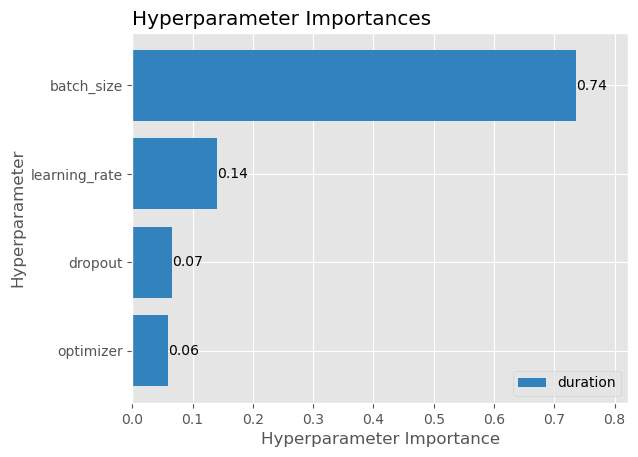

In [ ]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

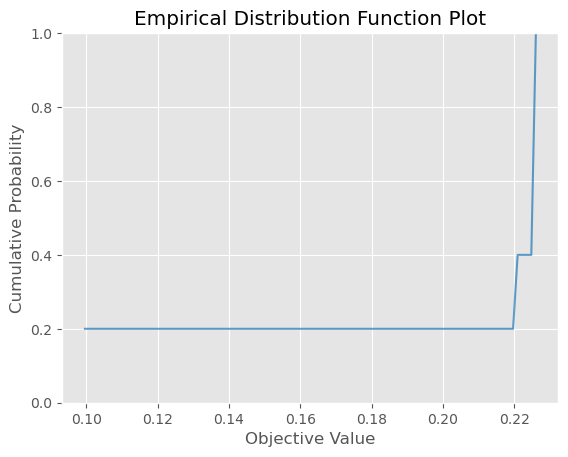

In [ ]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


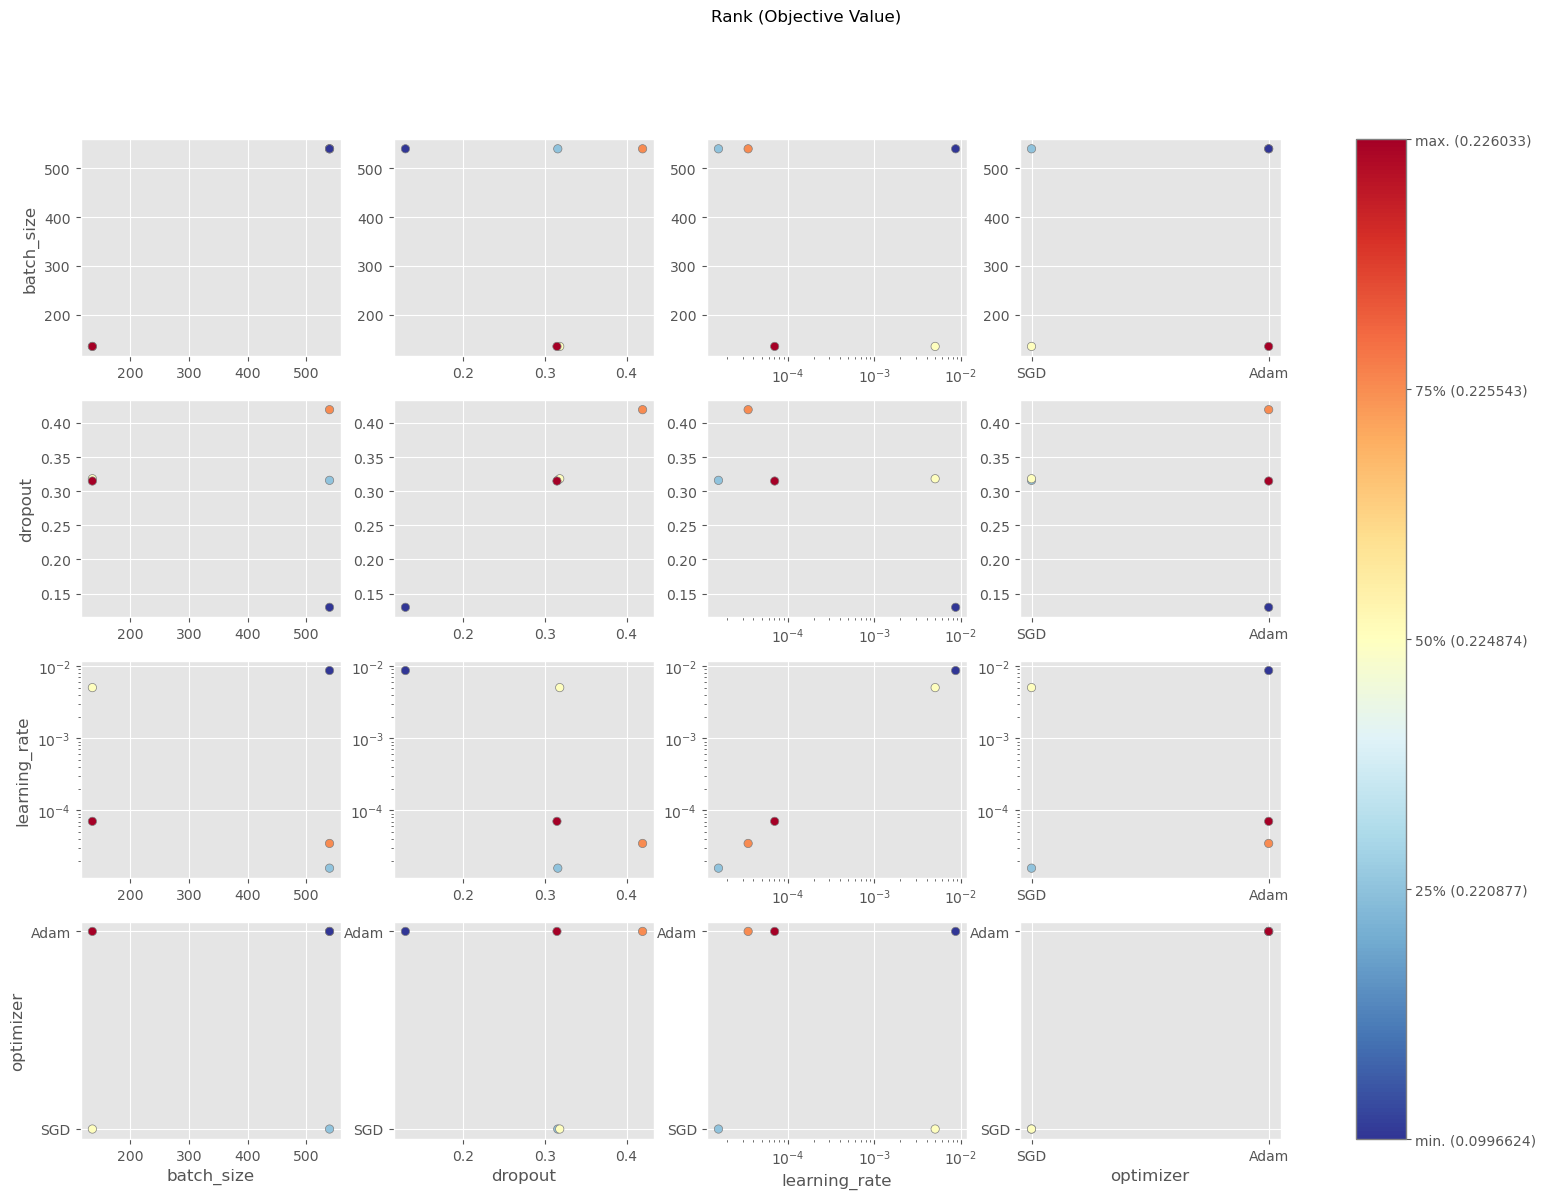

In [ ]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


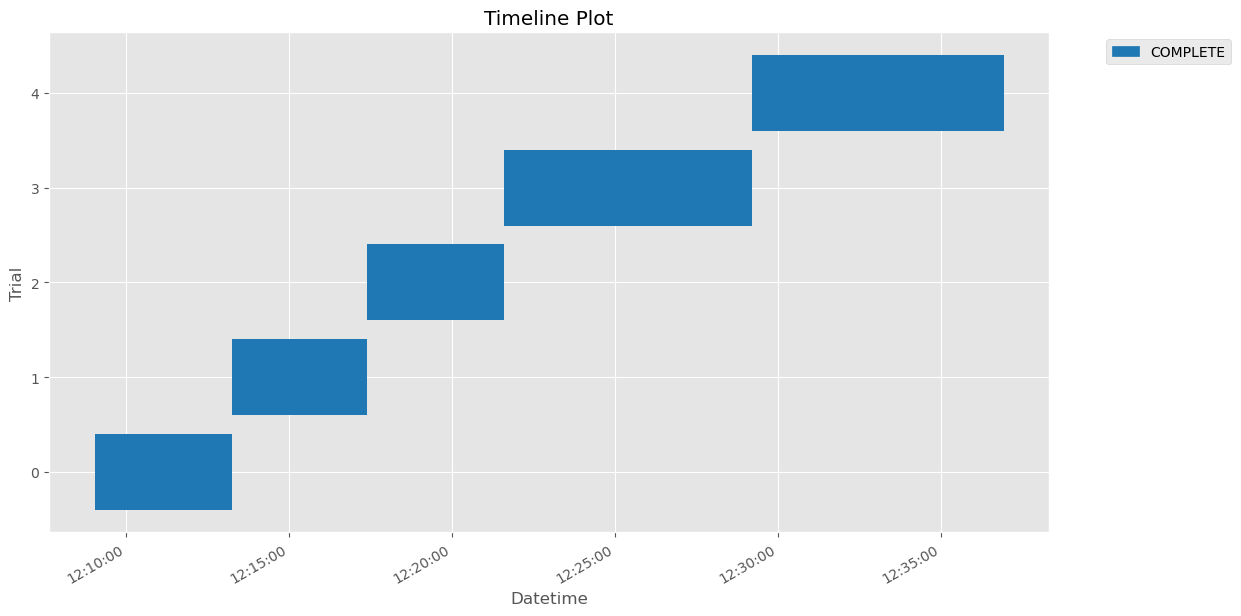

In [ ]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 2. EO feature set

In [168]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EO'][0]
baseline_val_idxs = data_split_indices['EO'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [eo_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[eo_y_list[i] for i in baseline_rest_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(eo_graph_dataset) = 2700
len(baseline_rest_idxs) = 2160, len(baseline_val_idxs) = 540, total: 2700
len(X_traintest) = 2160, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 444, total: 2160


### Model: graphLambda without edge_attr

In [169]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    # fc_layers = 1
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    # n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('eo_results_wo_edge_attrs_trials.pkl')

[I 2024-05-22 15:10:29,190] A new study created in memory with name: no-name-b6b6bb82-3ead-46a9-a325-168d0c91ddf2


Tested parameters: {'learning_rate': 0.03717859745417273, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.22679919194883827}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:13:27,336] Trial 0 finished with value: 0.06666667014360428 and parameters: {'learning_rate': 0.03717859745417273, 'optimizer': 'RMSprop', 'batch_size': 680, 'fc_layers': 3, 'dropout': 0.22679919194883827}. Best is trial 0 with value: 0.06666667014360428.


Best trial:
  Value: 0.06666667014360428
  Params: 
    learning_rate: 0.03717859745417273
    optimizer: RMSprop
    batch_size: 680
    fc_layers: 3
    dropout: 0.22679919194883827


In [170]:
df_trials = pd.read_pickle('eo_results_wo_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.066667 2024-05-22 15:10:29.192001 2024-05-22 15:13:27.334322   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:02:58.142321                680        0.226799                 3   

   params_learning_rate params_optimizer     state  
0              0.037179          RMSprop  COMPLETE

#### Visualizations

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

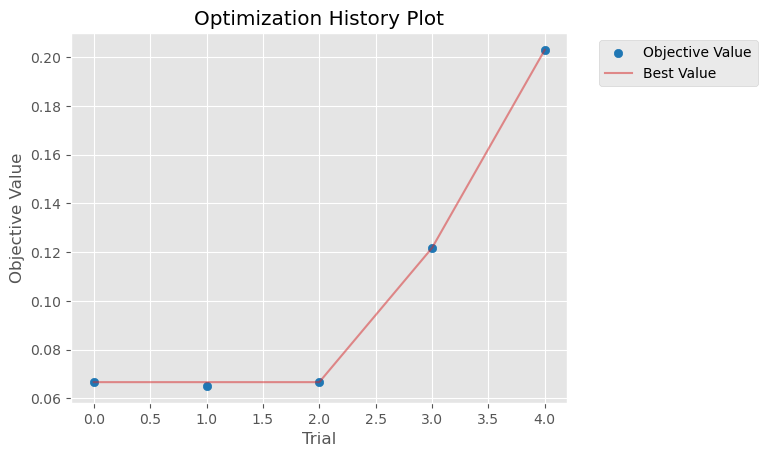

In [ ]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


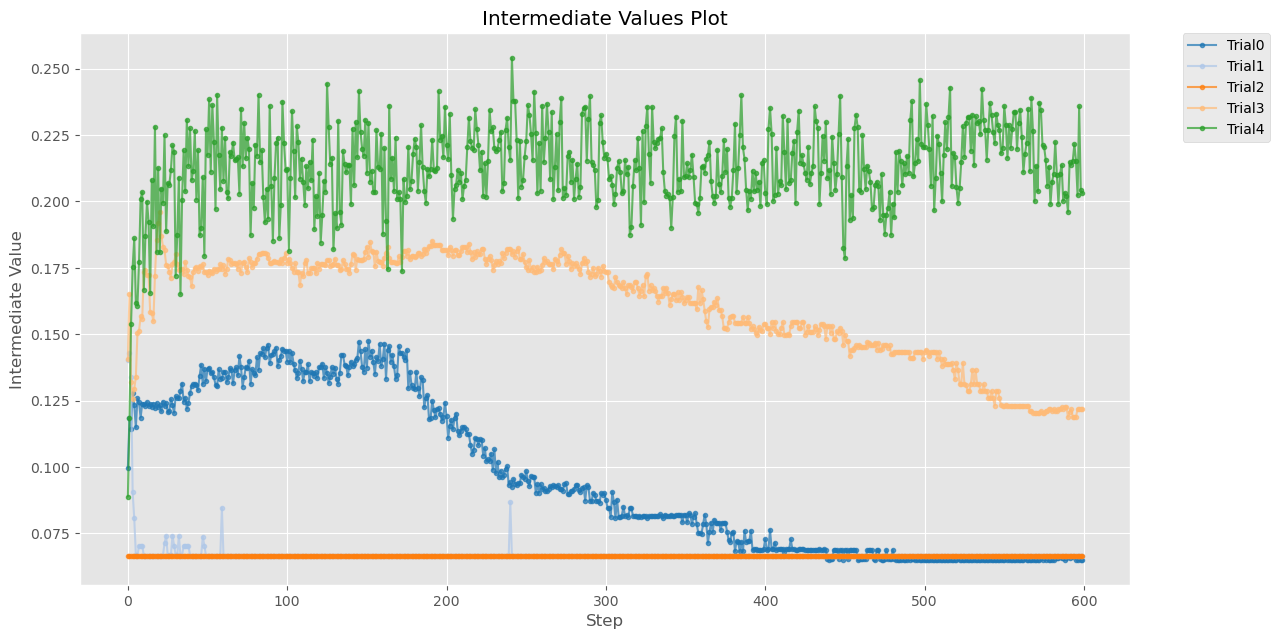

In [ ]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


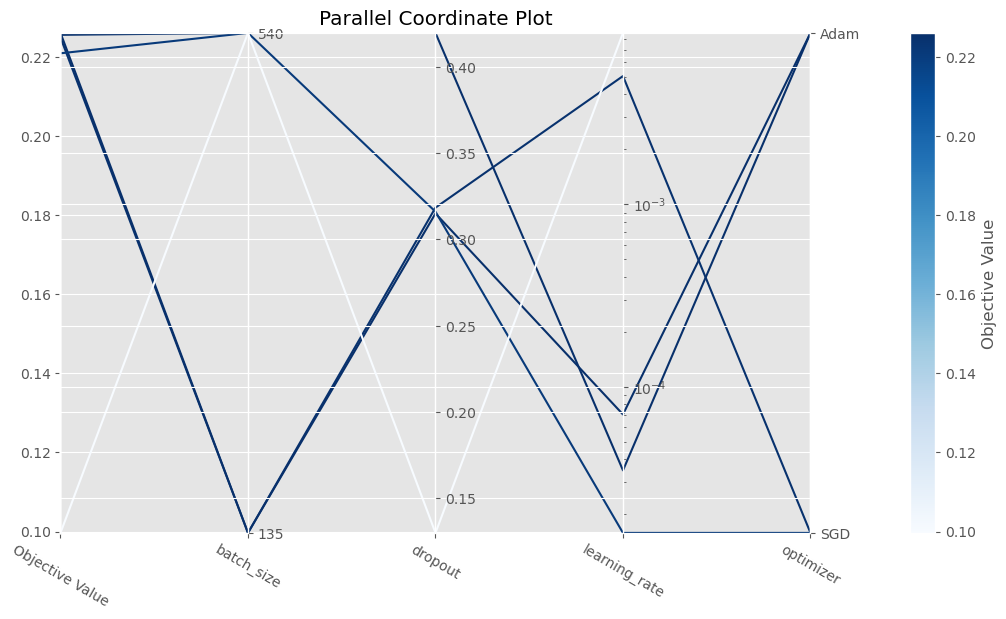

In [ ]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


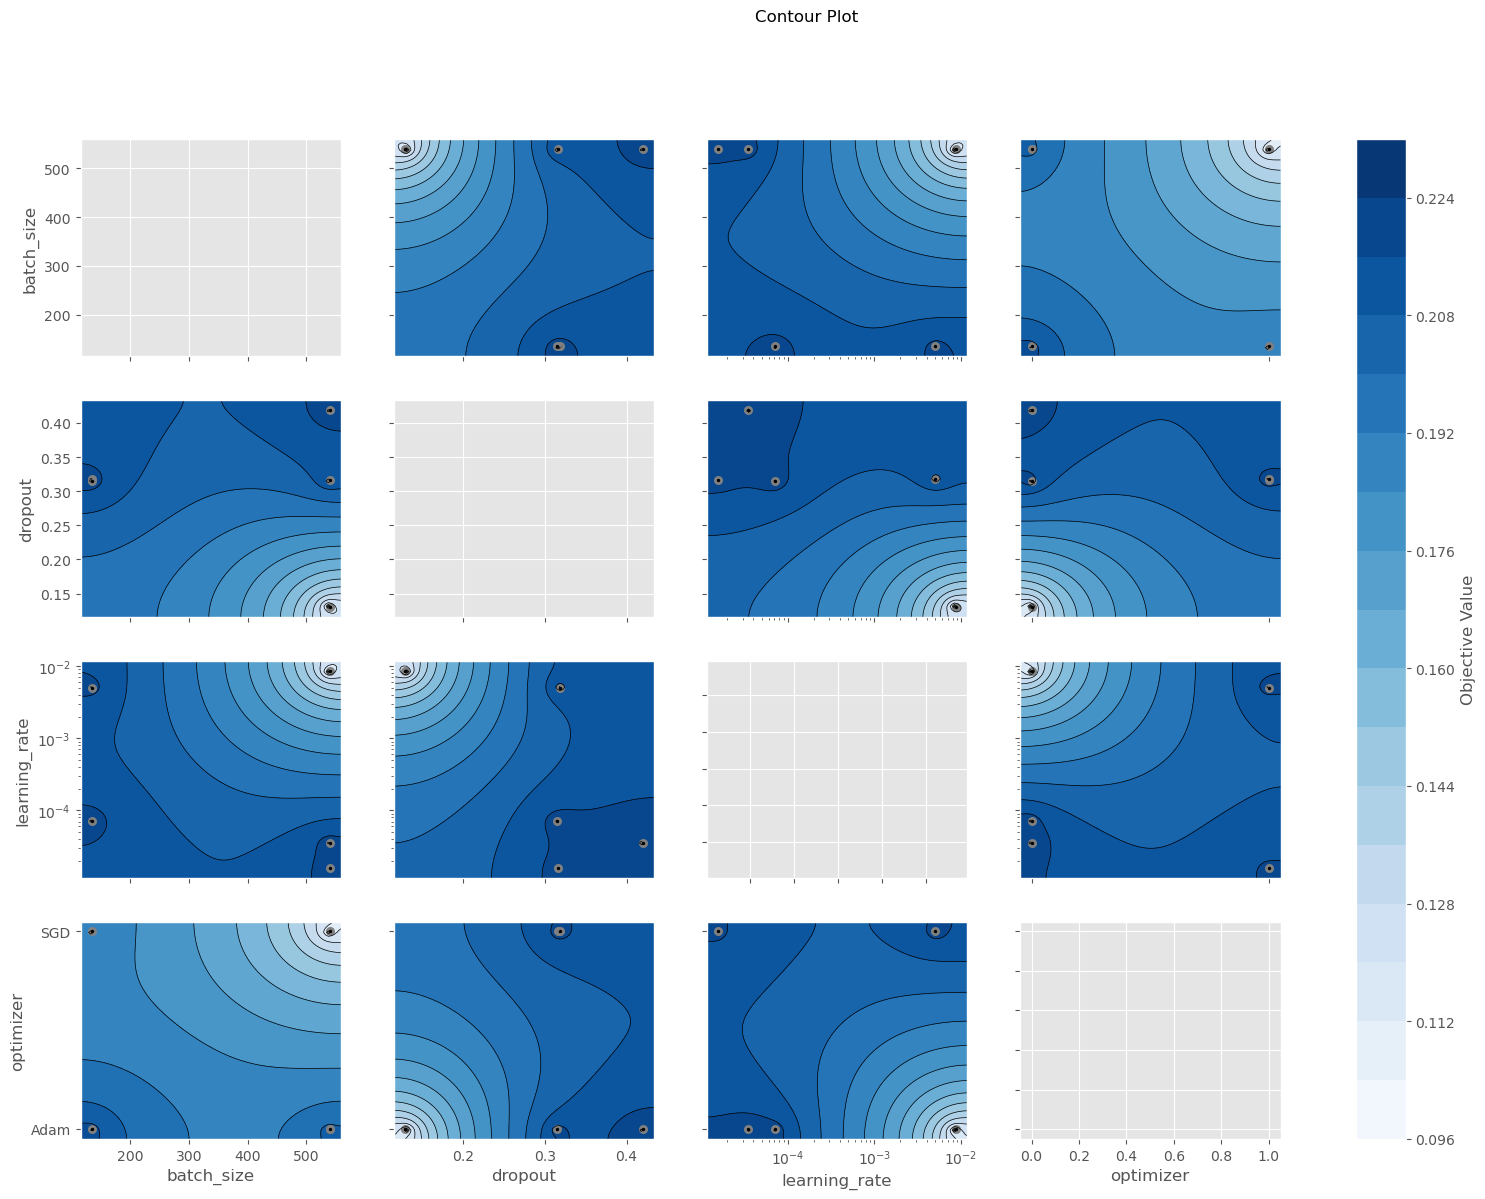

In [ ]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

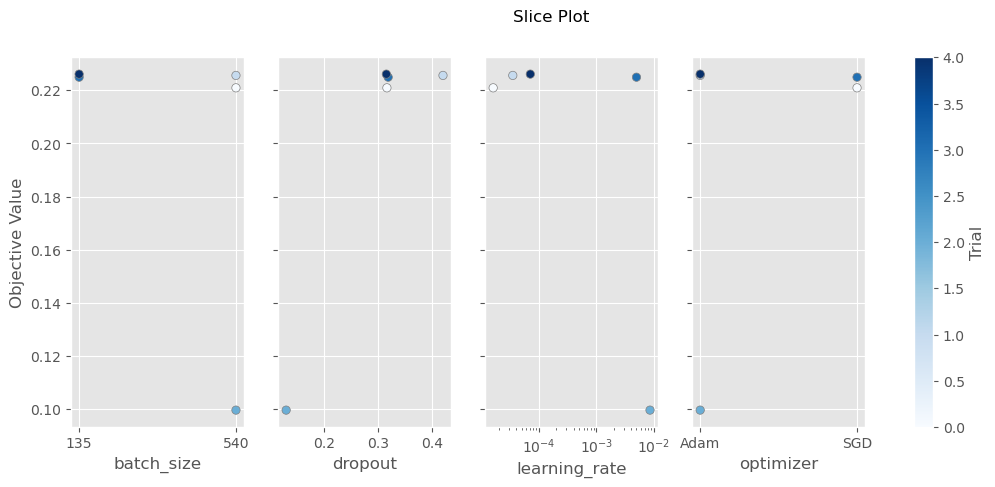

In [ ]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

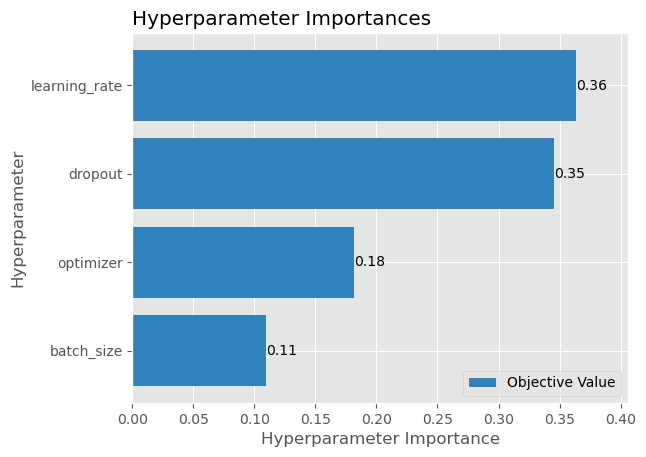

In [ ]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

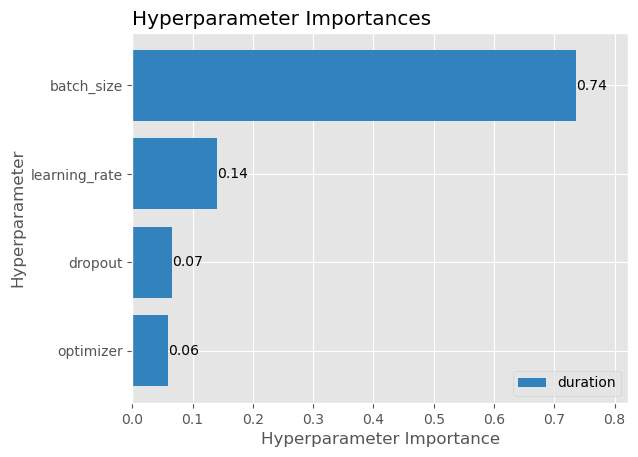

In [ ]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

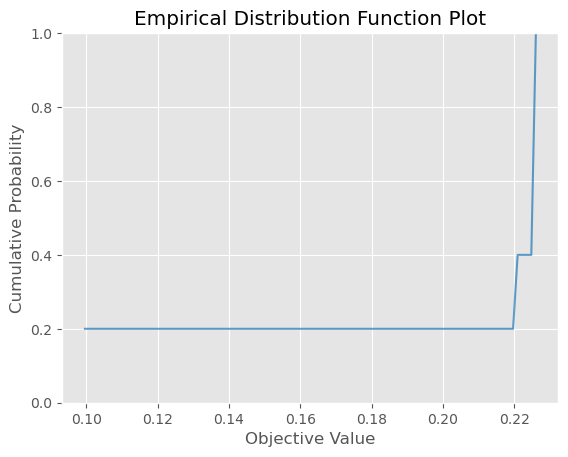

In [ ]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


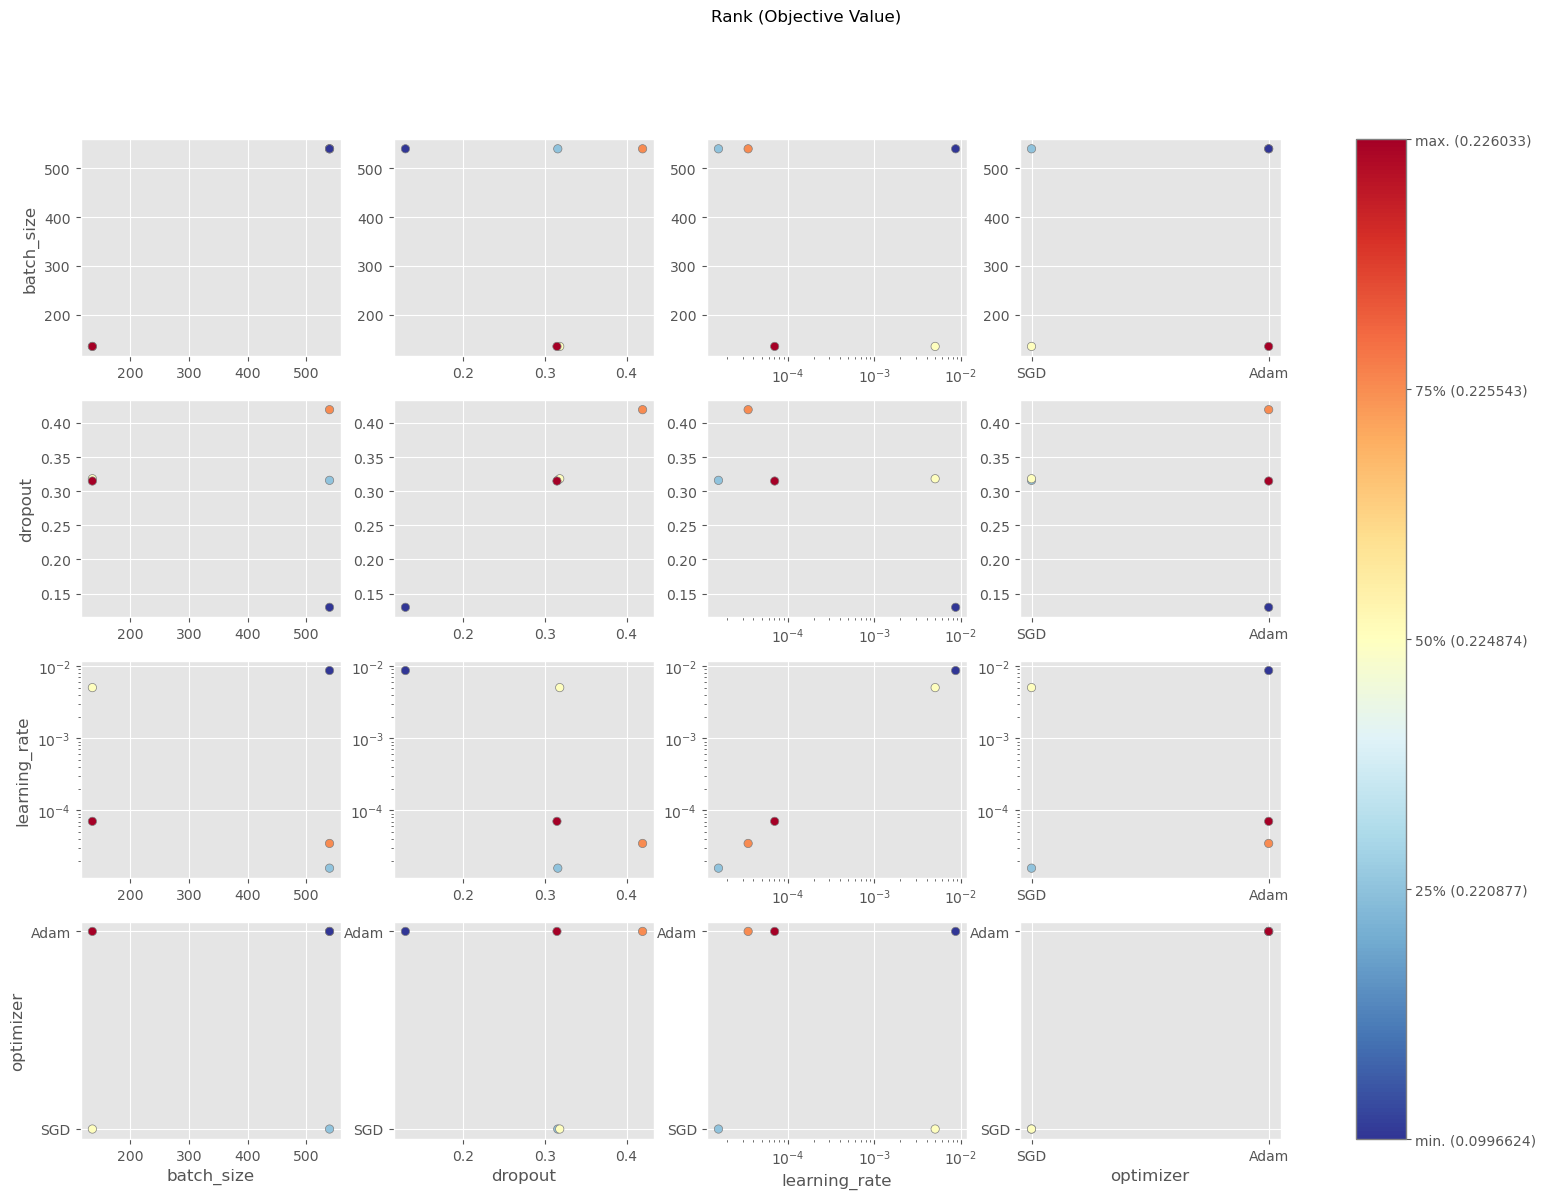

In [ ]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


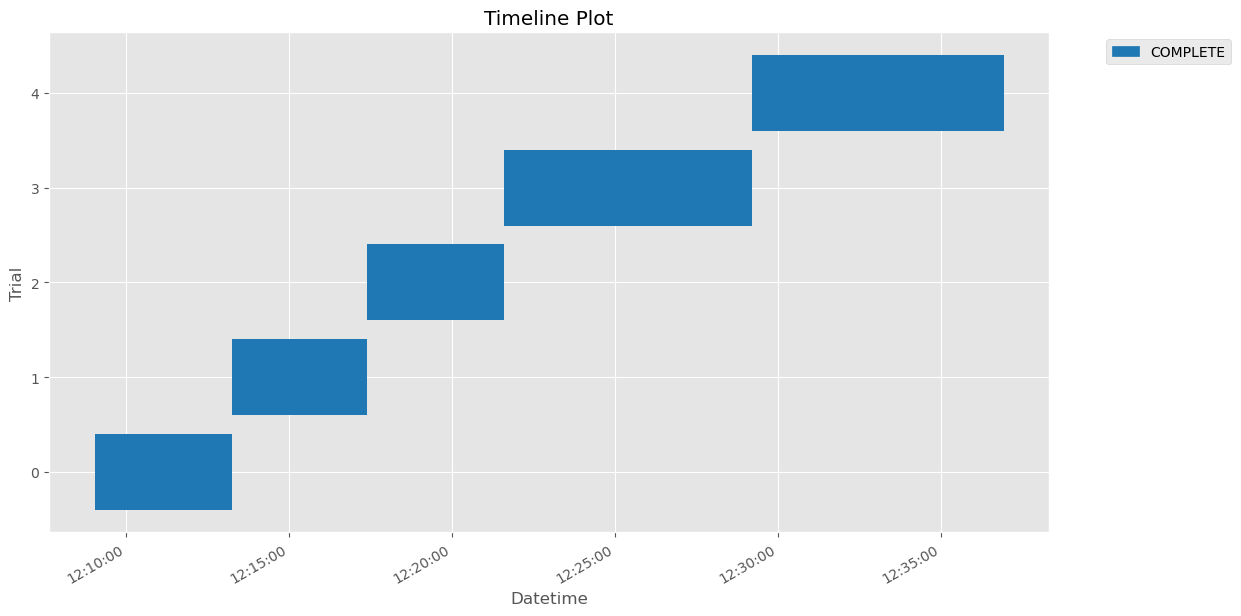

In [ ]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

### Model: graphLambda with edge_attr

In [171]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')


    # Create the model
    model = graphLambda_w_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_w_edge_attrs_trials.pkl')

[I 2024-05-22 15:13:27,441] A new study created in memory with name: no-name-8eb7e4d5-0761-43be-8b7c-69537f8cb430


Tested parameters: {'learning_rate': 0.0003186781906880119, 'optimizer_name': 'Adam', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.24478967666433527}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:17:45,549] Trial 0 finished with value: 0.2297118902206421 and parameters: {'learning_rate': 0.0003186781906880119, 'optimizer': 'Adam', 'batch_size': 510, 'fc_layers': 3, 'dropout': 0.24478967666433527}. Best is trial 0 with value: 0.2297118902206421.


Best trial:
  Value: 0.2297118902206421
  Params: 
    learning_rate: 0.0003186781906880119
    optimizer: Adam
    batch_size: 510
    fc_layers: 3
    dropout: 0.24478967666433527


In [172]:
df_trials = pd.read_pickle('ec_results_w_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.229712 2024-05-22 15:13:27.443434 2024-05-22 15:17:45.546199   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:04:18.102765                510         0.24479                 3   

   params_learning_rate params_optimizer     state  
0              0.000319             Adam  COMPLETE

#### Visualizations

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

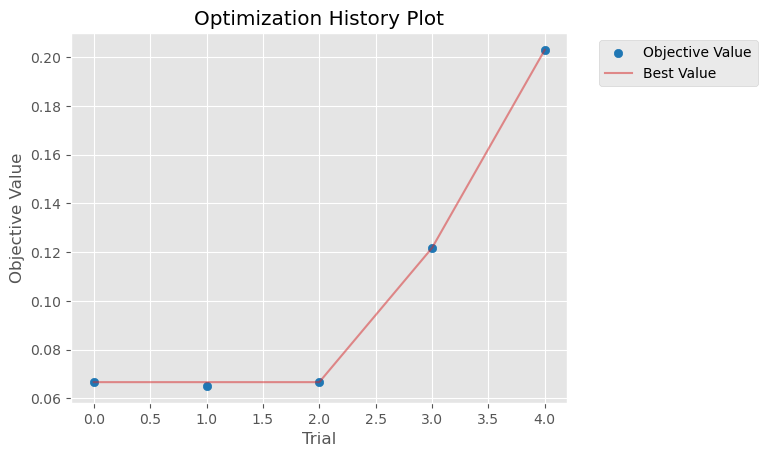

In [ ]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


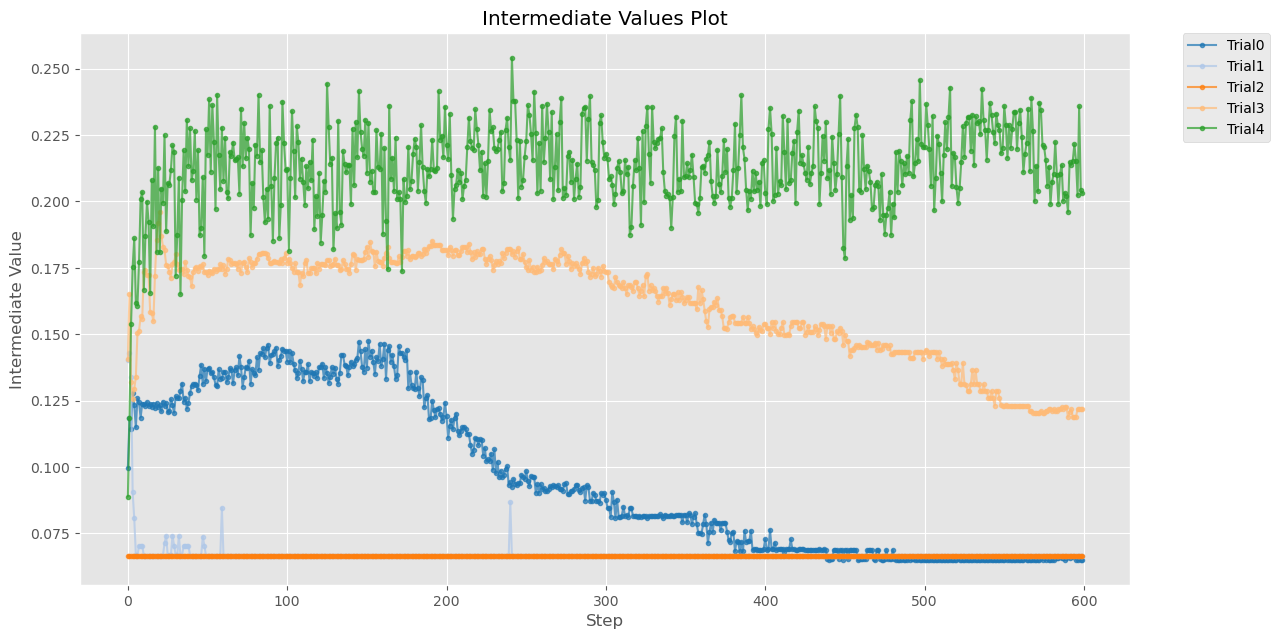

In [ ]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


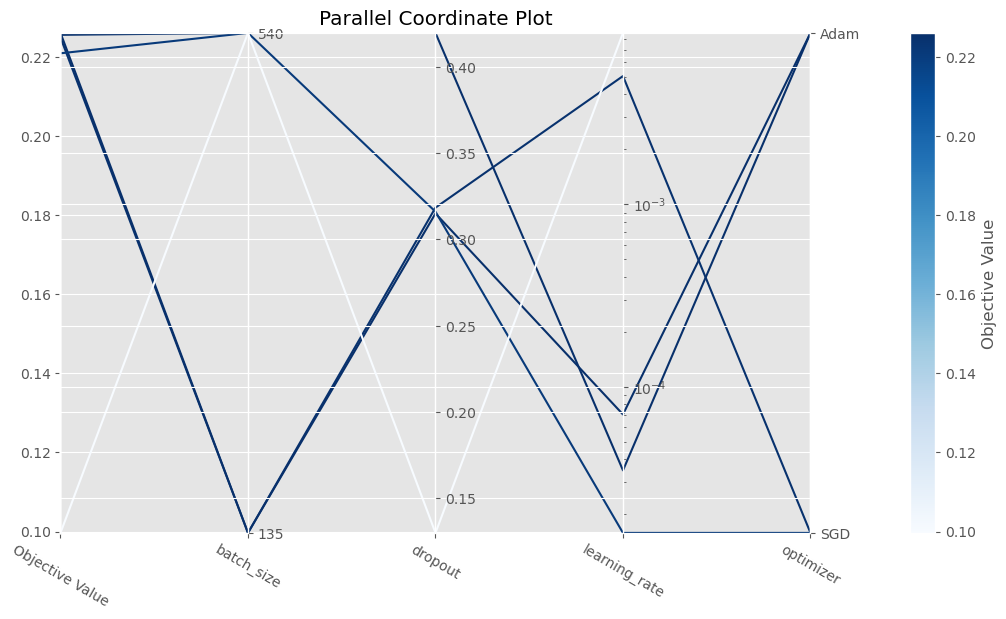

In [ ]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


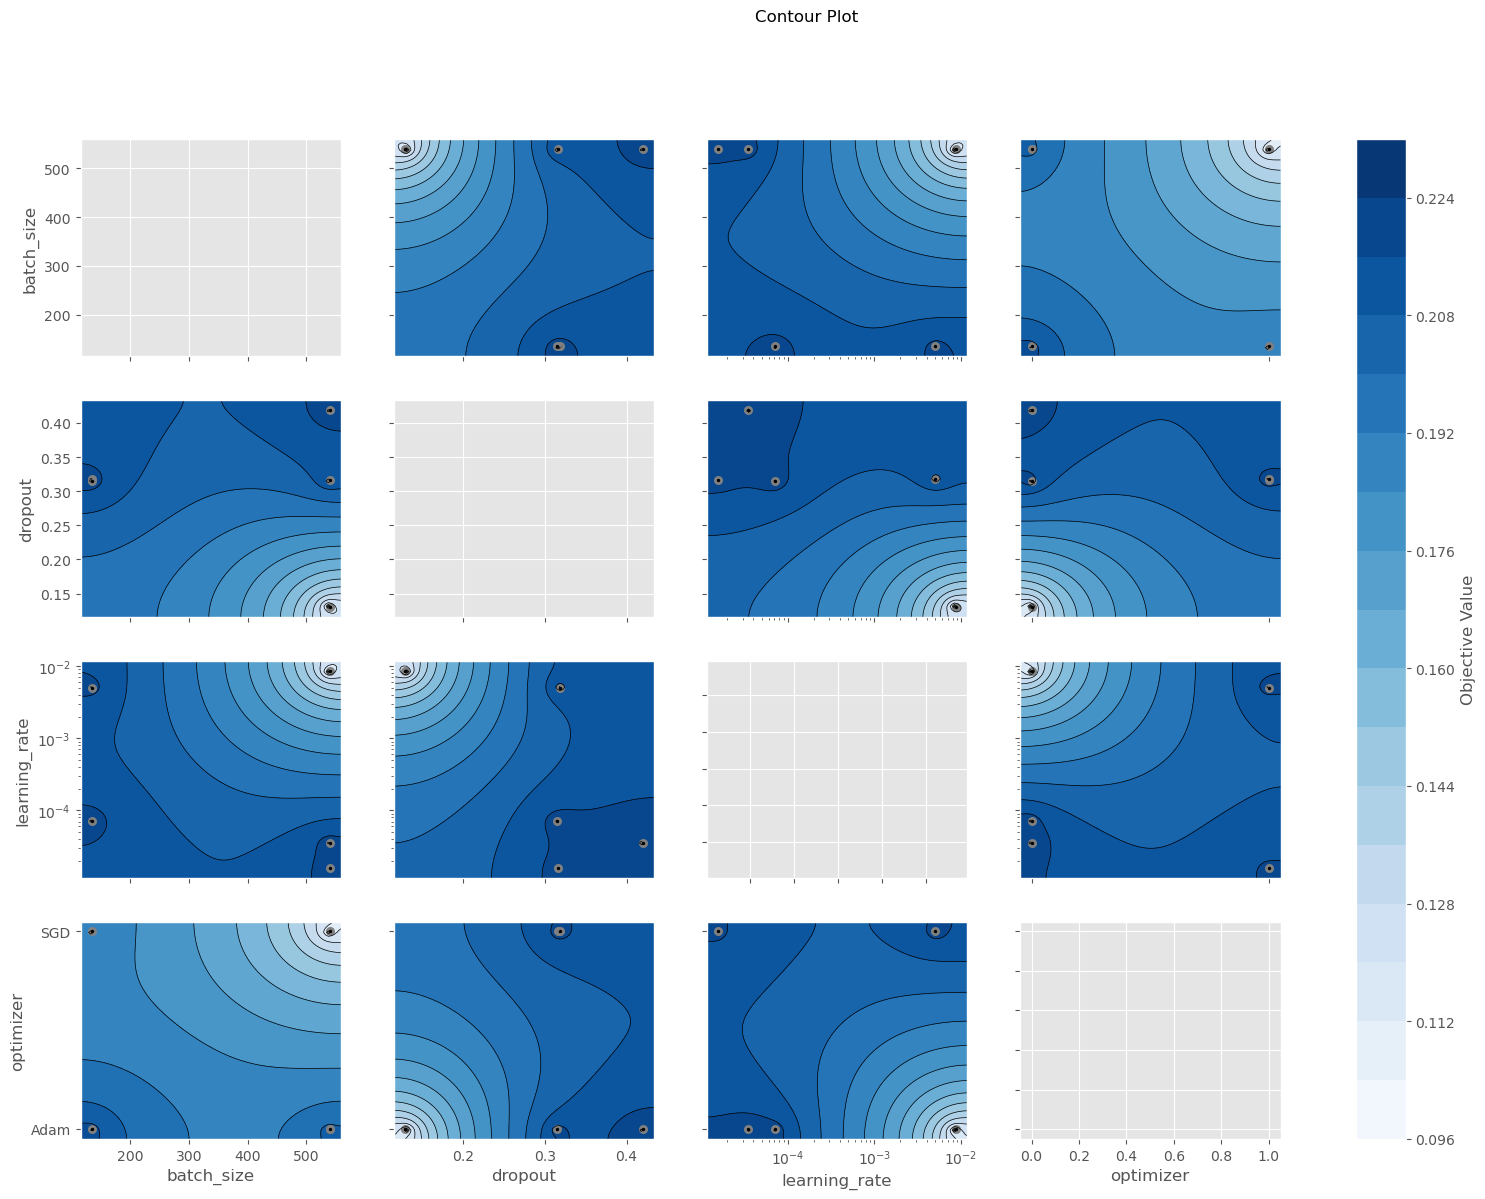

In [ ]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

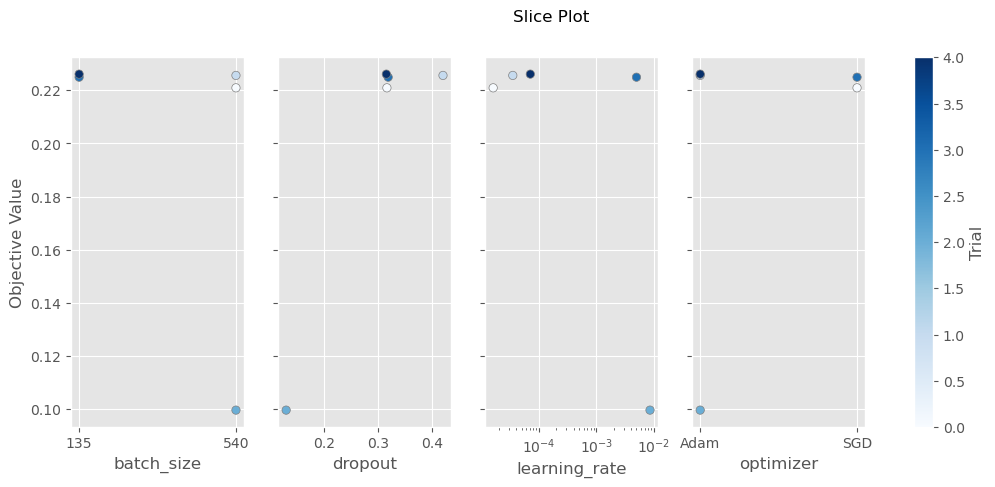

In [ ]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

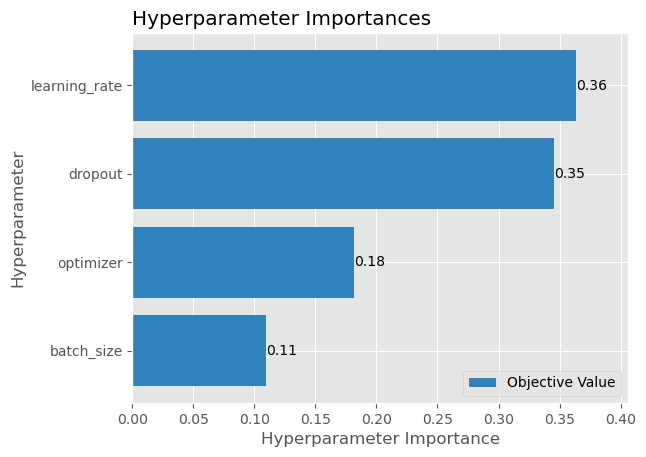

In [ ]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

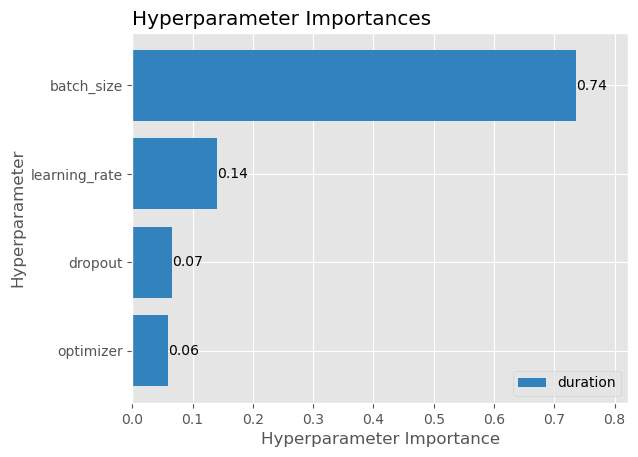

In [ ]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

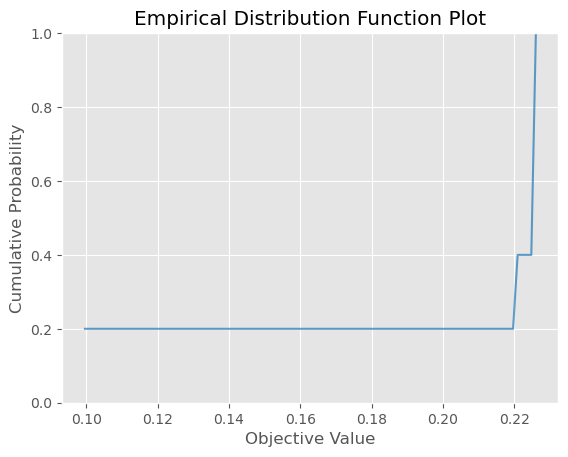

In [ ]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


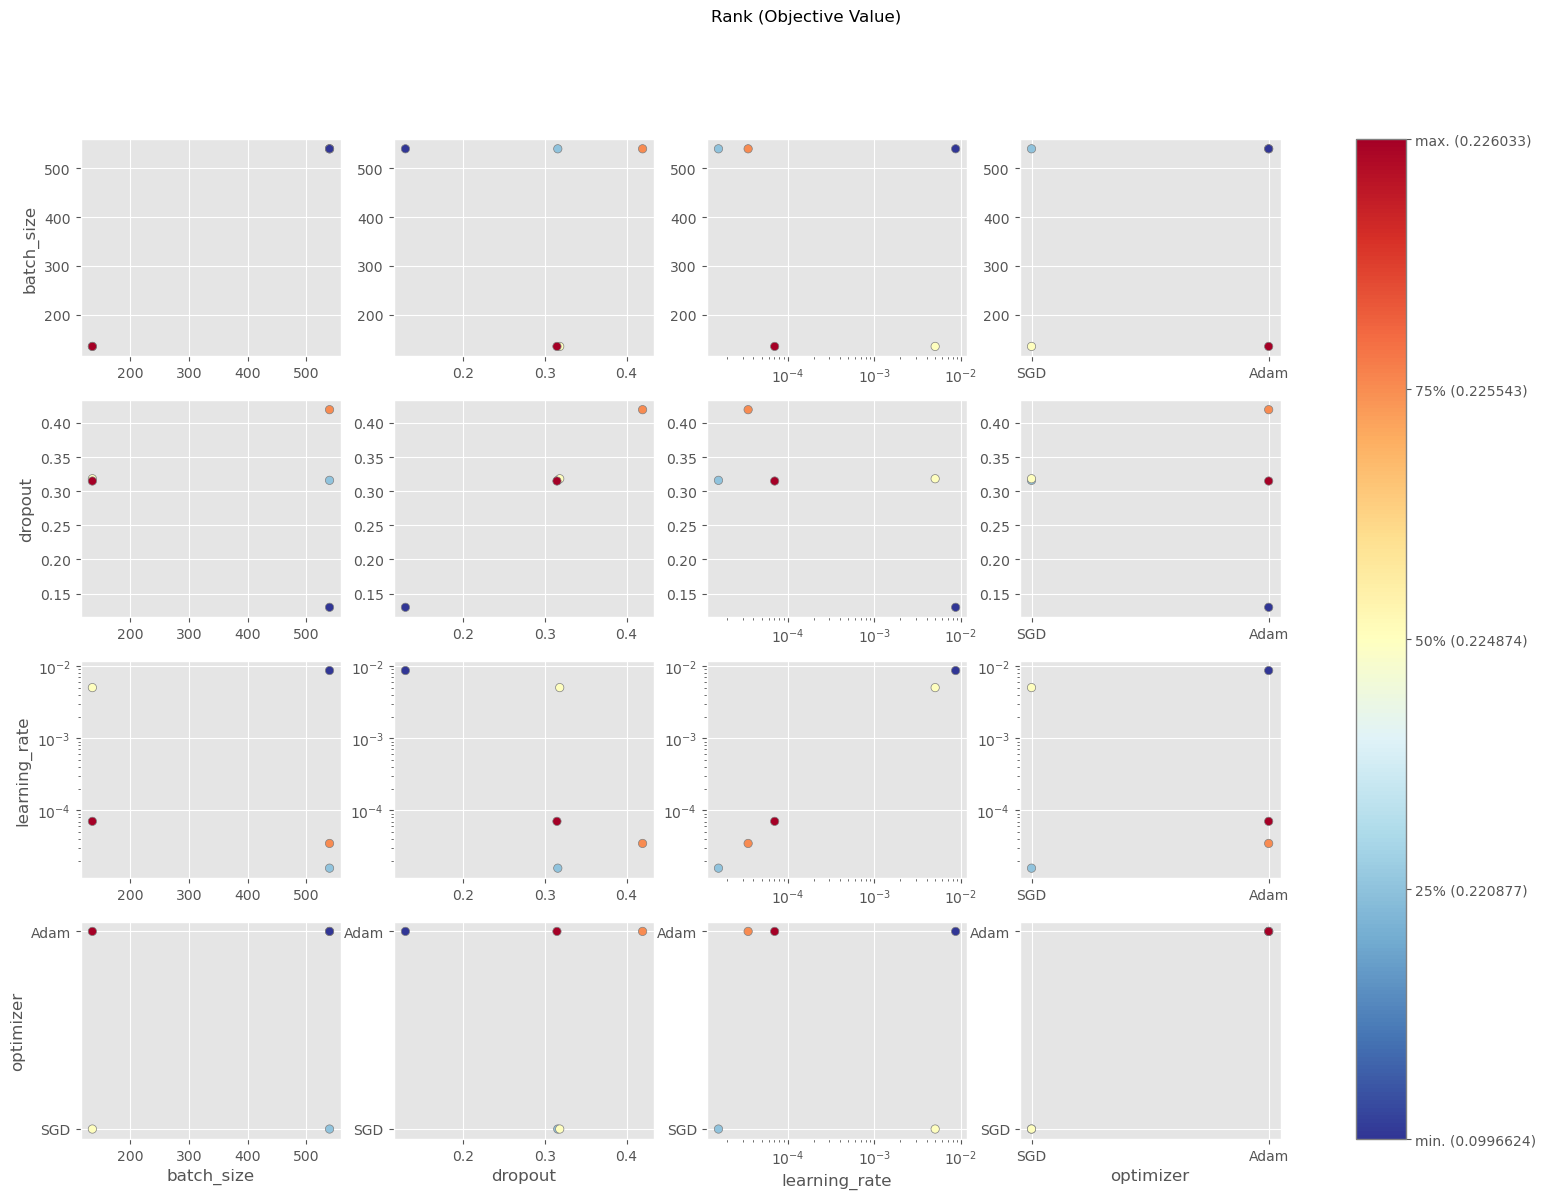

In [ ]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


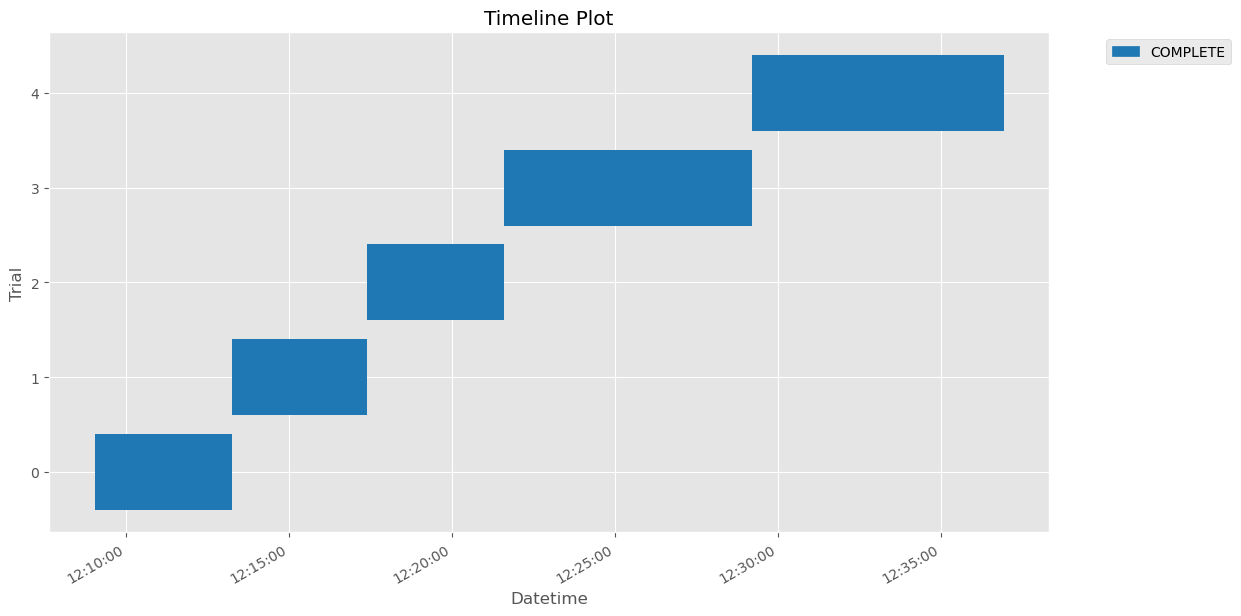

In [ ]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 3. ratio feature set

In [173]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['ratio'][0]
baseline_val_idxs = data_split_indices['ratio'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ratio_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ratio_y_list[i] for i in baseline_rest_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ratio_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


### Model: graphLambda without edge_attr

In [174]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    # fc_layers = 1
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    # n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = graphLambda_wo_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ratio_results_wo_edge_attrs_trials.pkl')

[I 2024-05-22 15:17:45,814] A new study created in memory with name: no-name-df22d179-6e36-4b0d-90b3-e2be362c44da


Tested parameters: {'learning_rate': 4.6168484066735374e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.11321535538781352}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:22:03,696] Trial 0 finished with value: 0.1309853494167328 and parameters: {'learning_rate': 4.6168484066735374e-05, 'optimizer': 'SGD', 'batch_size': 340, 'fc_layers': 4, 'dropout': 0.11321535538781352}. Best is trial 0 with value: 0.1309853494167328.


Best trial:
  Value: 0.1309853494167328
  Params: 
    learning_rate: 4.6168484066735374e-05
    optimizer: SGD
    batch_size: 340
    fc_layers: 4
    dropout: 0.11321535538781352


In [ ]:
df_trials = pd.read_pickle('ratio_results_wo_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.066667 2024-05-22 15:10:29.192001 2024-05-22 15:13:27.334322   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:02:58.142321                680        0.226799                 3   

   params_learning_rate params_optimizer     state  
0              0.037179          RMSprop  COMPLETE

#### Visualizations

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

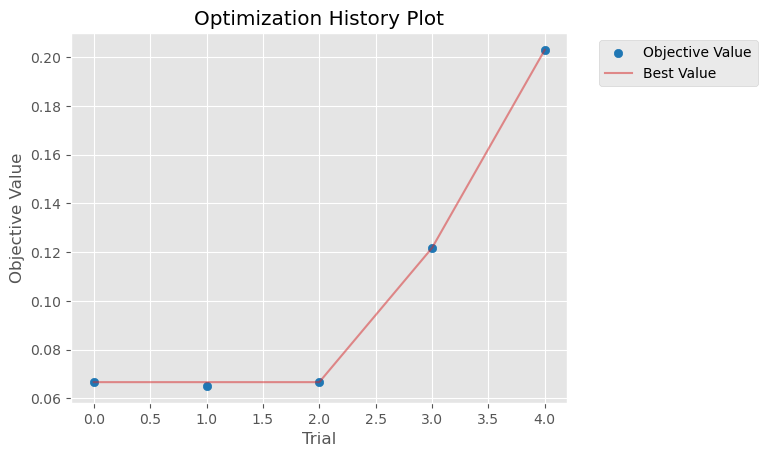

In [ ]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


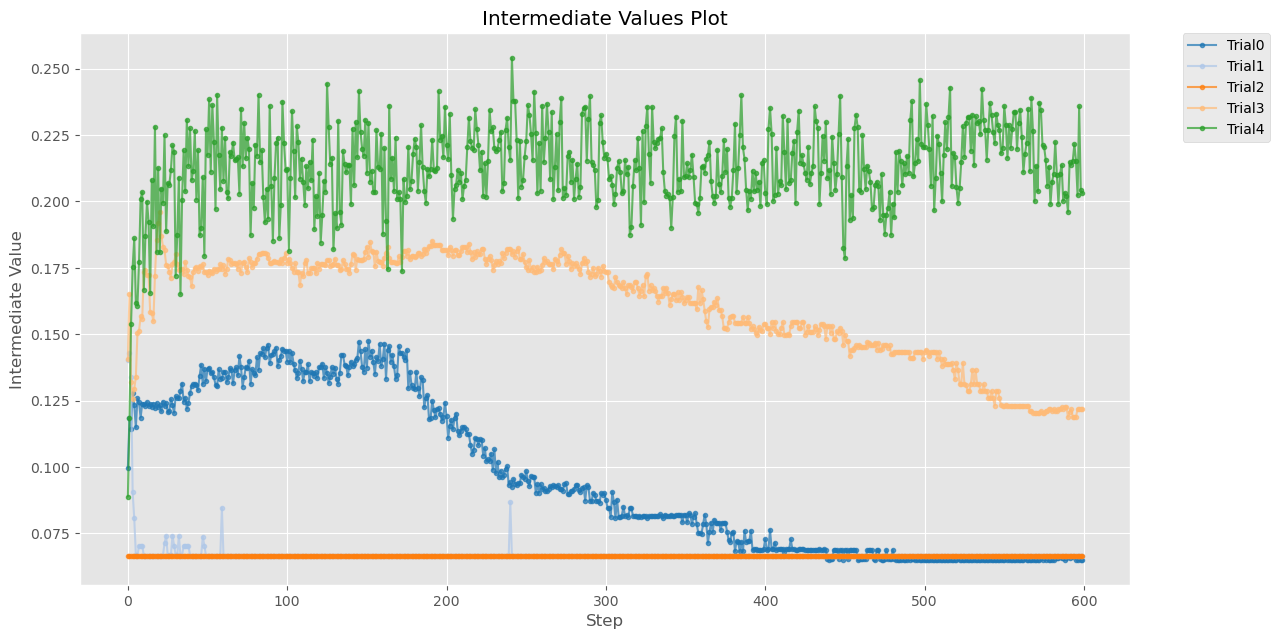

In [ ]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


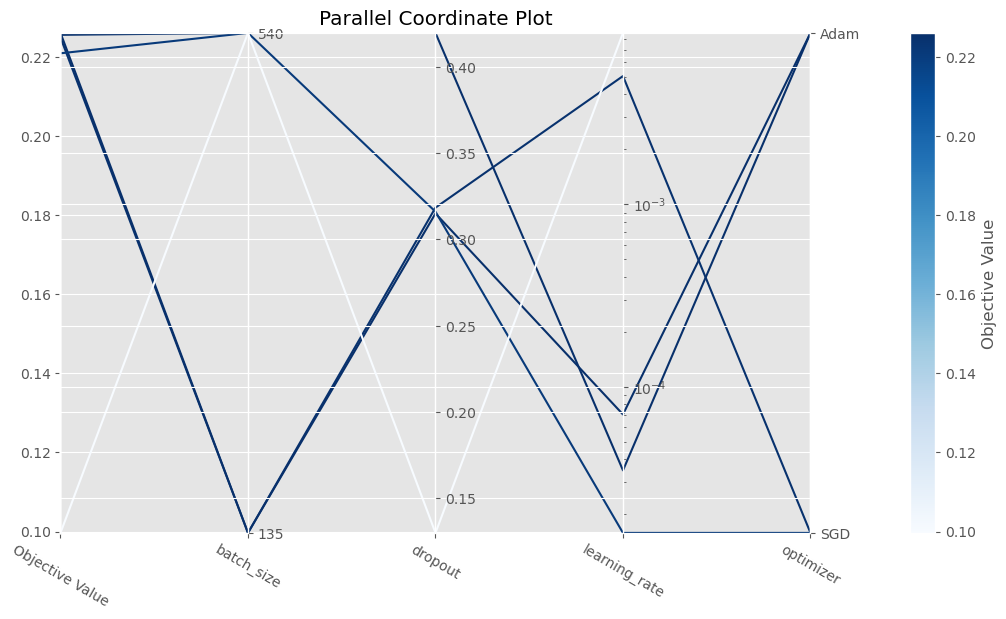

In [ ]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


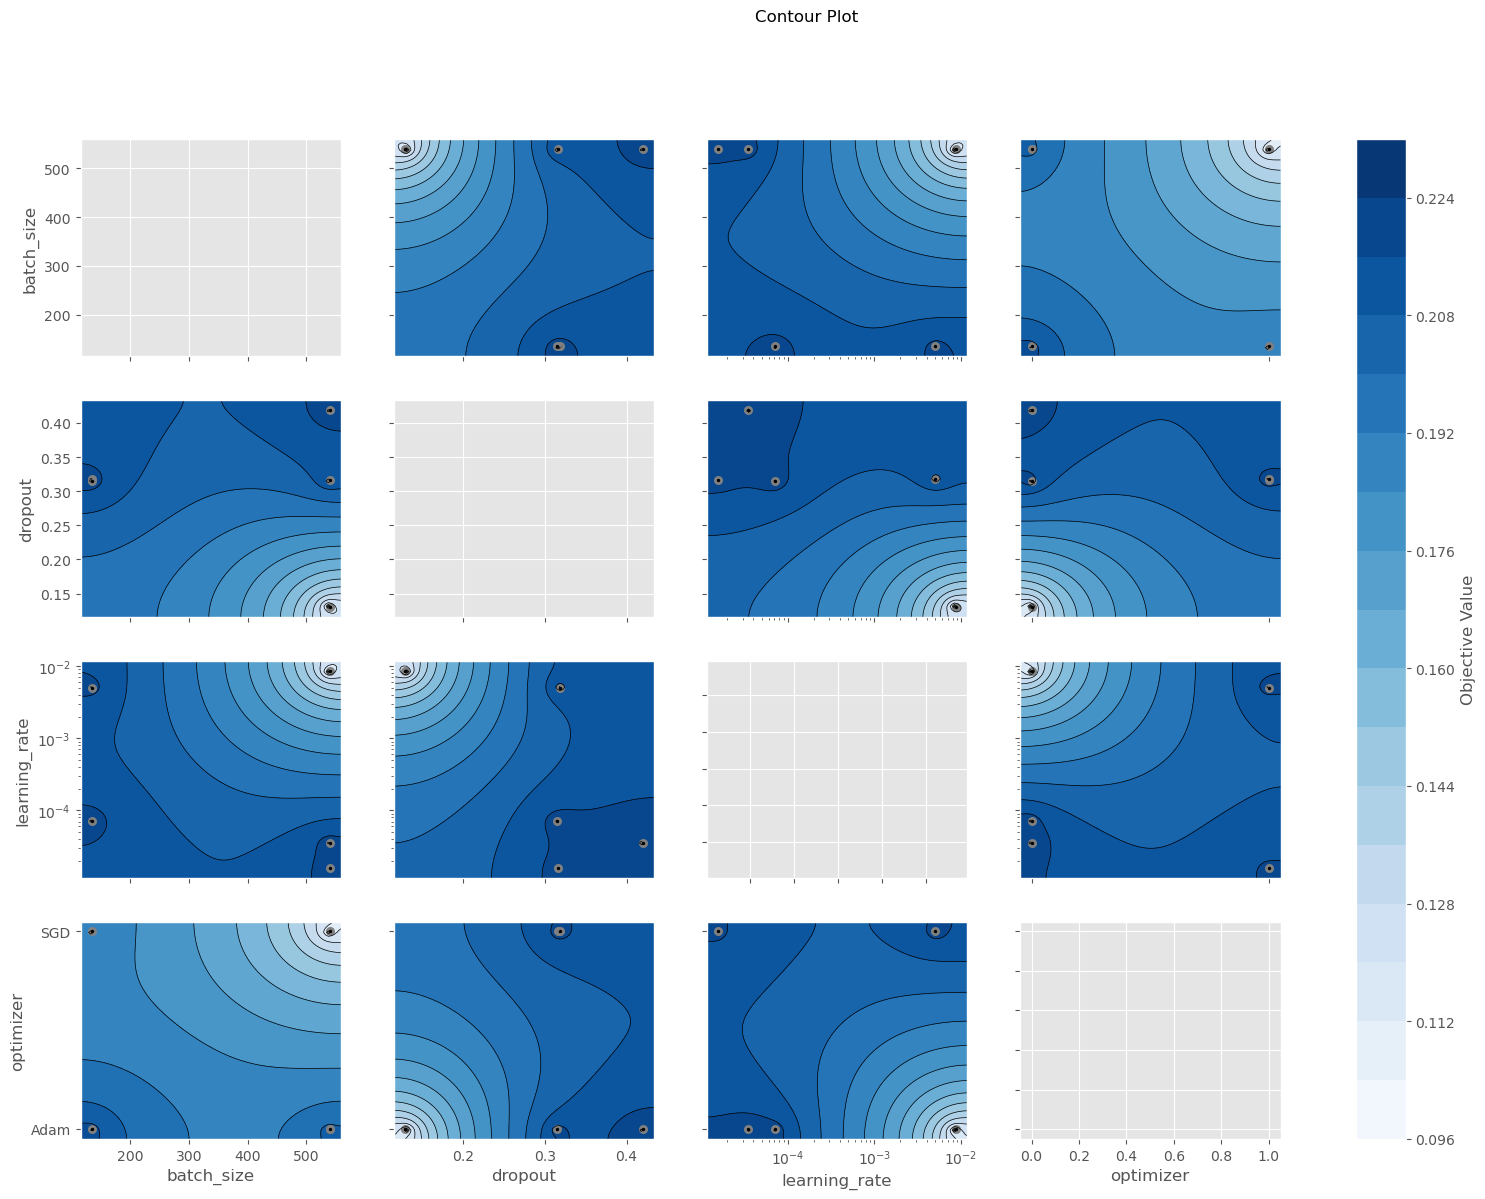

In [ ]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

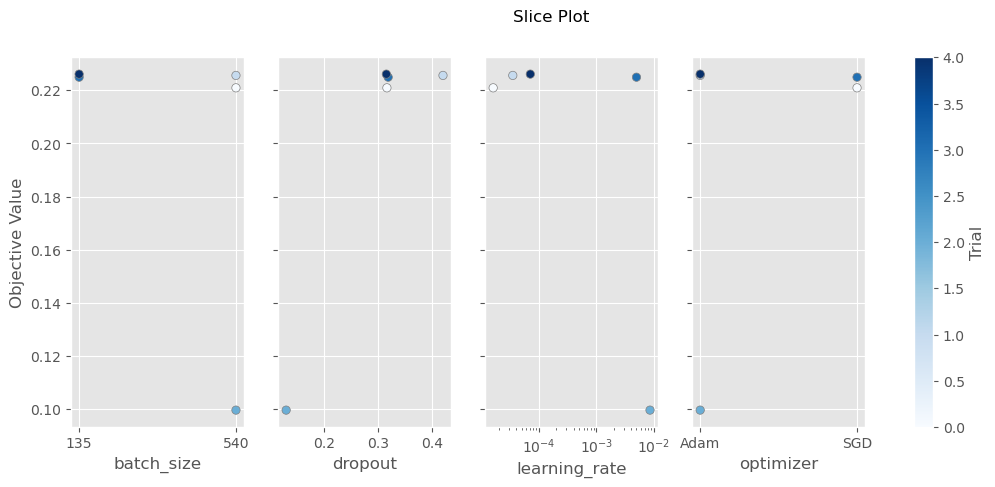

In [ ]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

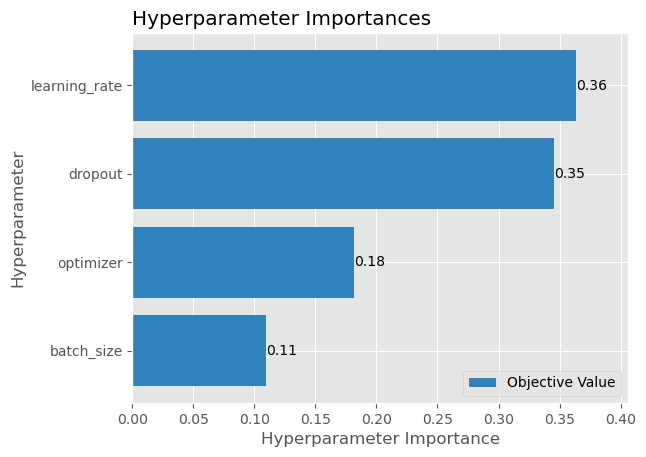

In [ ]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

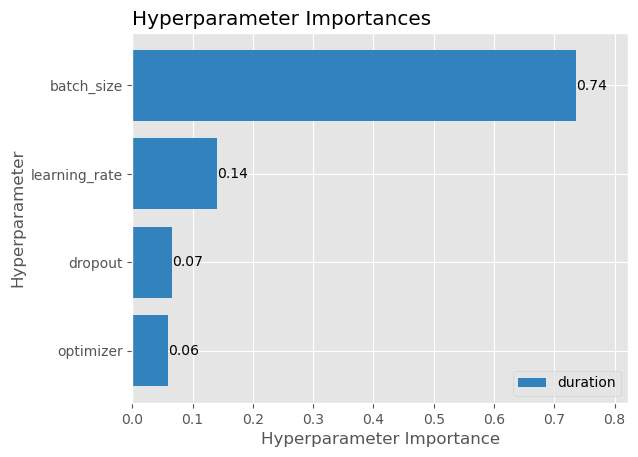

In [ ]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

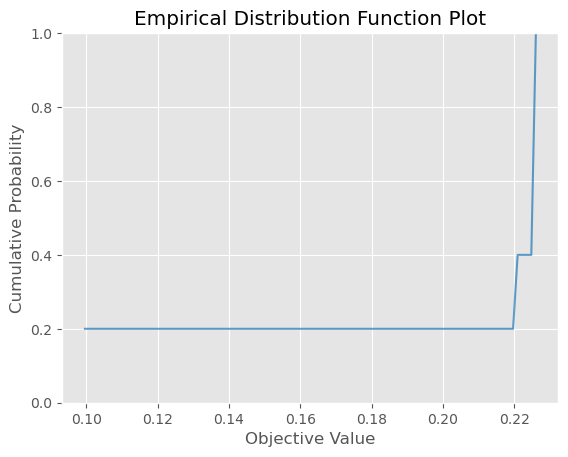

In [ ]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


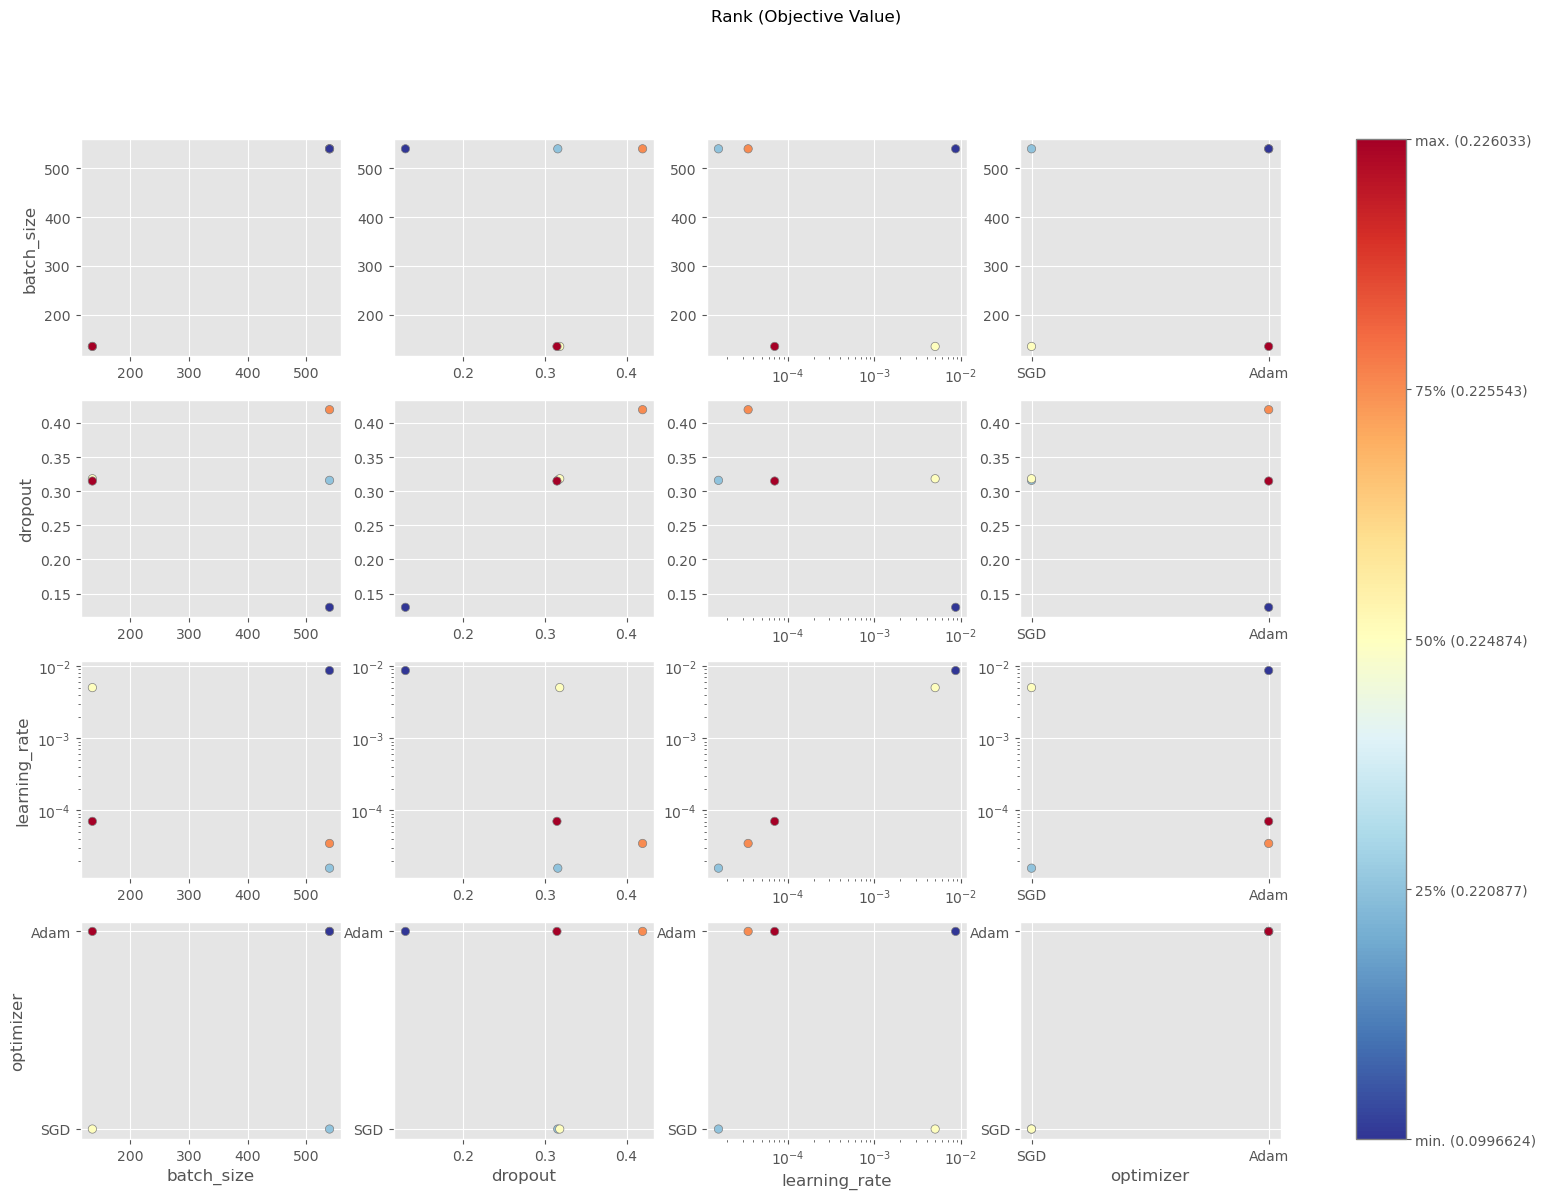

In [ ]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


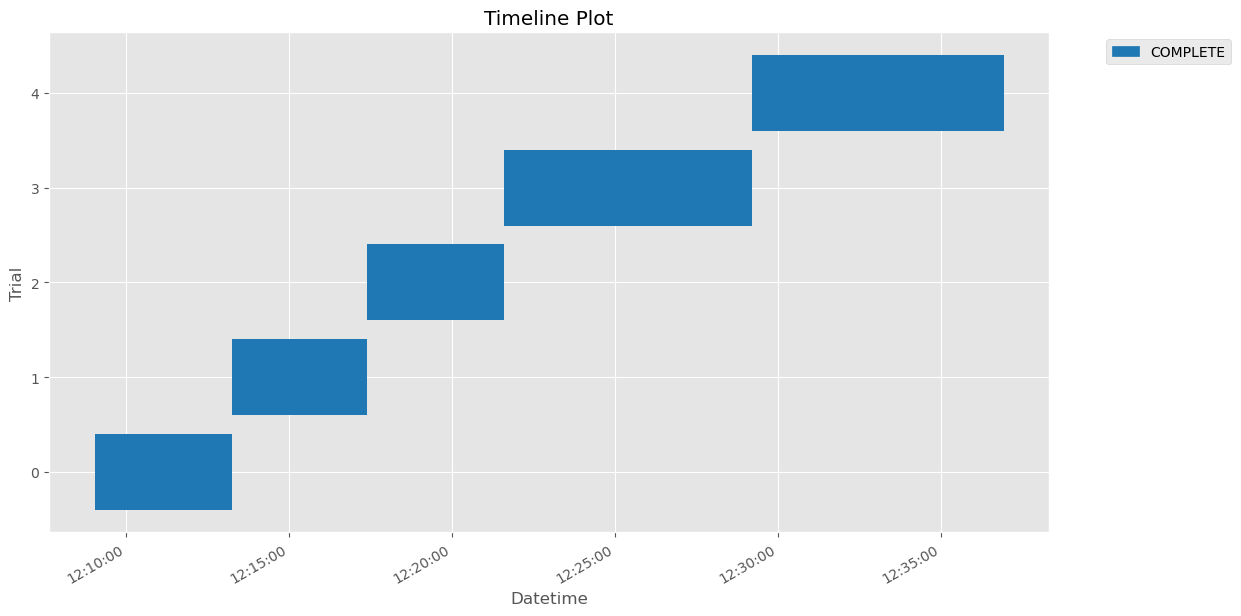

In [ ]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

### Model: graphLambda with edge_attr

In [175]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    fc_layers = trial.suggest_int('fc_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, fc_layers=fc_layers, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')


    # Create the model
    model = graphLambda_w_edge_attr(learning_rate=learning_rate, optimizer_name=optimizer_name, fc_layers=fc_layers, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=800,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ratio_results_w_edge_attrs_trials.pkl')

[I 2024-05-22 15:22:03,797] A new study created in memory with name: no-name-1cf6d593-8dca-404f-a1ed-f5476f2ee89e


Tested parameters: {'learning_rate': 0.0080289831555486, 'optimizer_name': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.5048633925107816}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-05-22 15:28:34,194] Trial 0 finished with value: 0.06666667014360428 and parameters: {'learning_rate': 0.0080289831555486, 'optimizer': 'SGD', 'batch_size': 170, 'fc_layers': 4, 'dropout': 0.5048633925107816}. Best is trial 0 with value: 0.06666667014360428.


Best trial:
  Value: 0.06666667014360428
  Params: 
    learning_rate: 0.0080289831555486
    optimizer: SGD
    batch_size: 170
    fc_layers: 4
    dropout: 0.5048633925107816


In [176]:
df_trials = pd.read_pickle('ratio_results_w_edge_attrs_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
0       0  0.066667 2024-05-22 15:22:03.799887 2024-05-22 15:28:34.192370   

                duration  params_batch_size  params_dropout  params_fc_layers  \
0 0 days 00:06:30.392483                170        0.504863                 4   

   params_learning_rate params_optimizer     state  
0              0.008029              SGD  COMPLETE

#### Visualizations

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

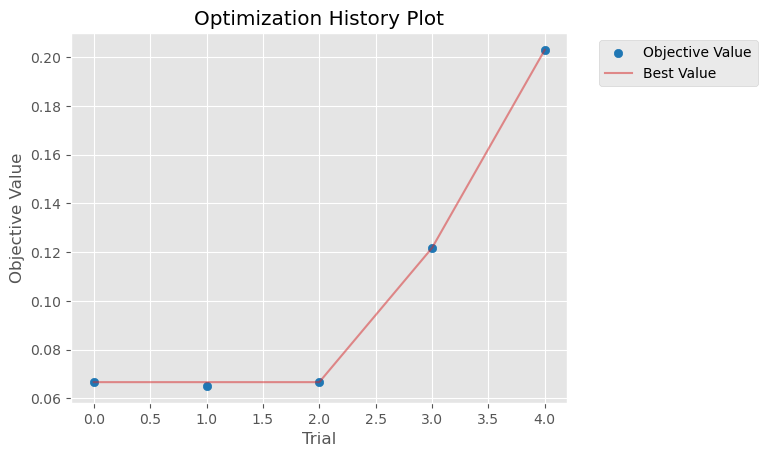

In [ ]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-05-22 13:10:47,122] A new study created in memory with name: no-name-86b62173-71a7-4b61-9d63-0812f11d1168
C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1240065685.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


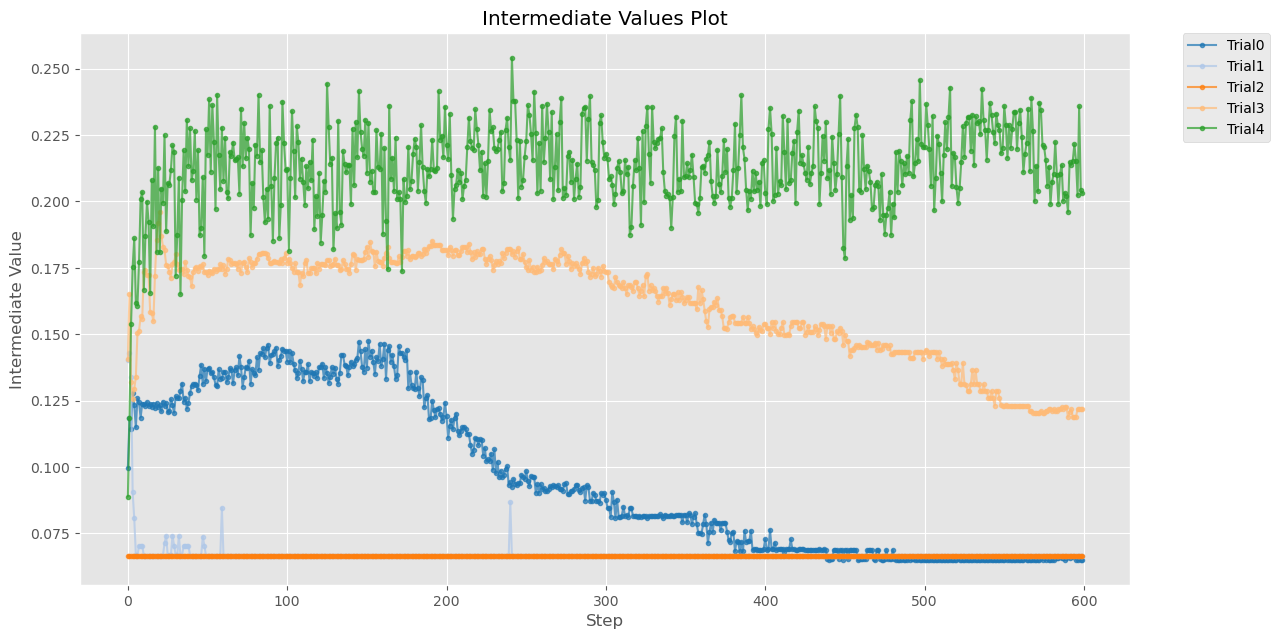

In [ ]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


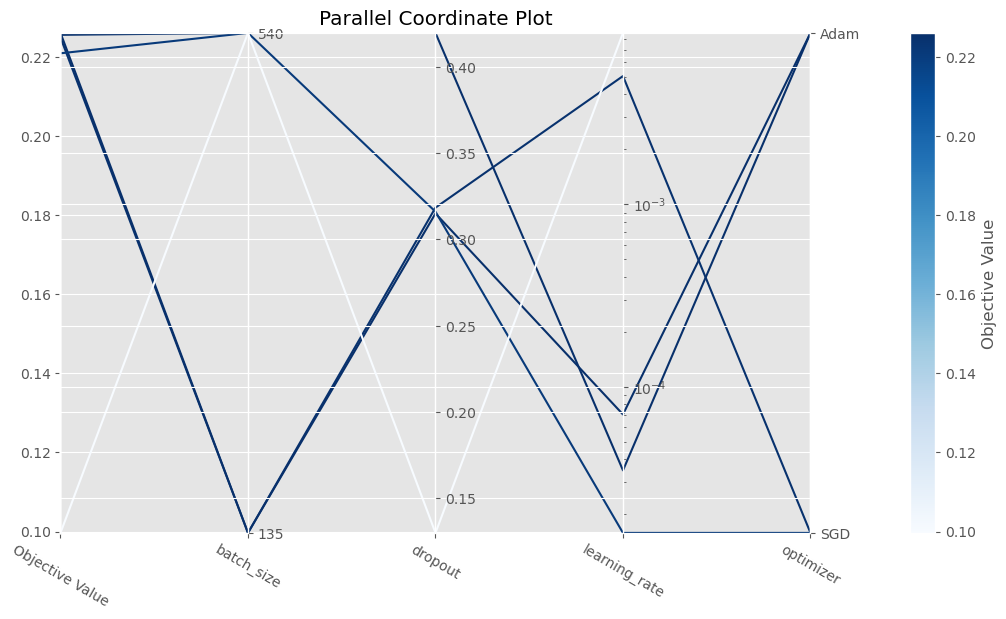

In [ ]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-05-22 12:36:57,329] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


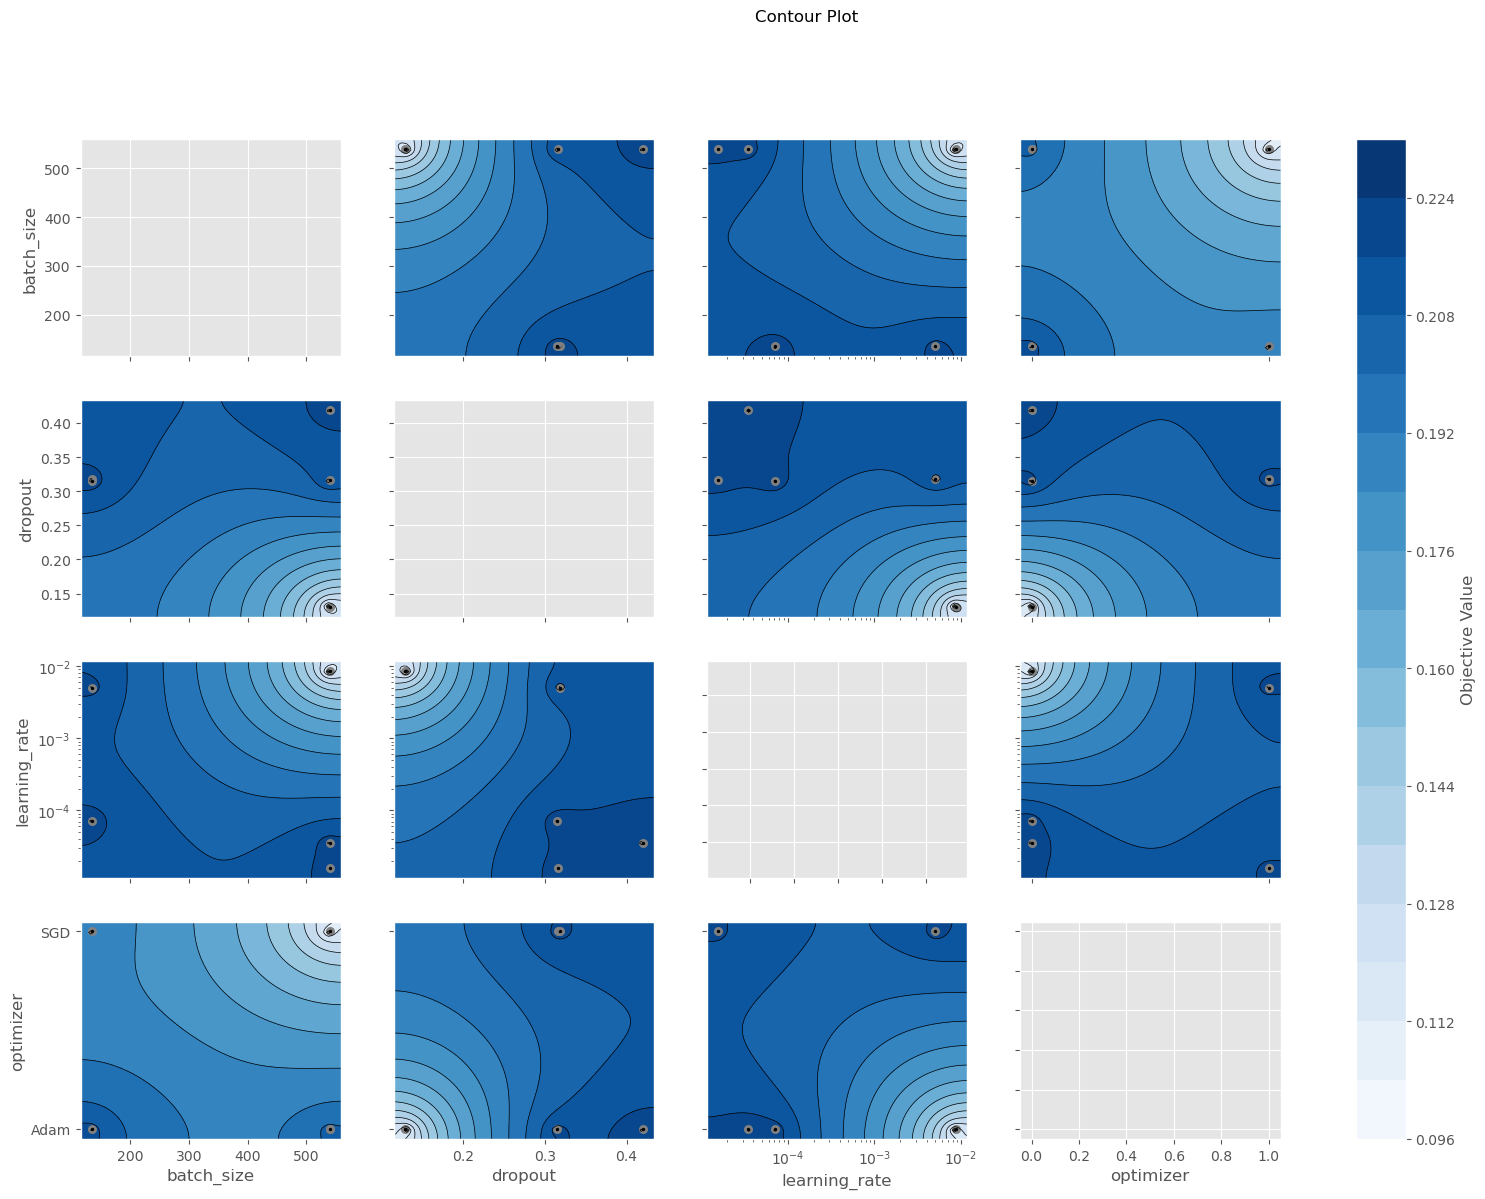

In [ ]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

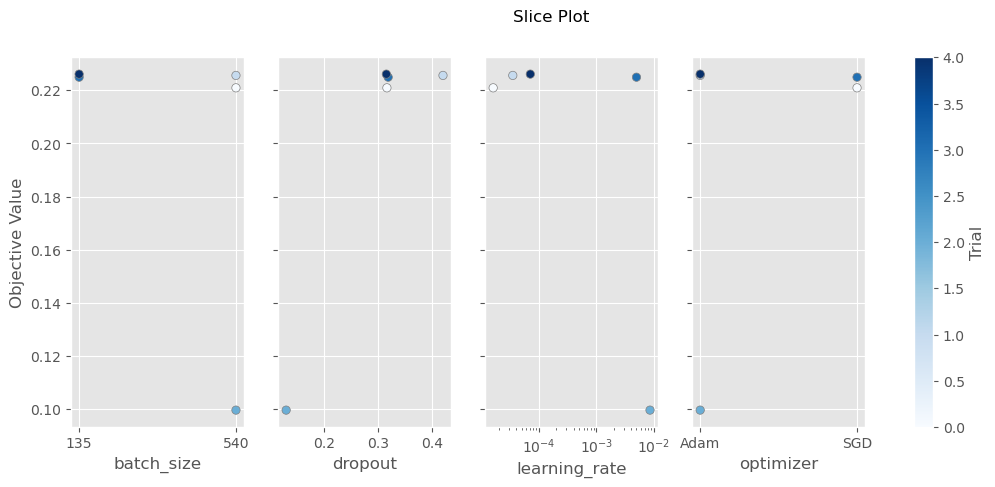

In [ ]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

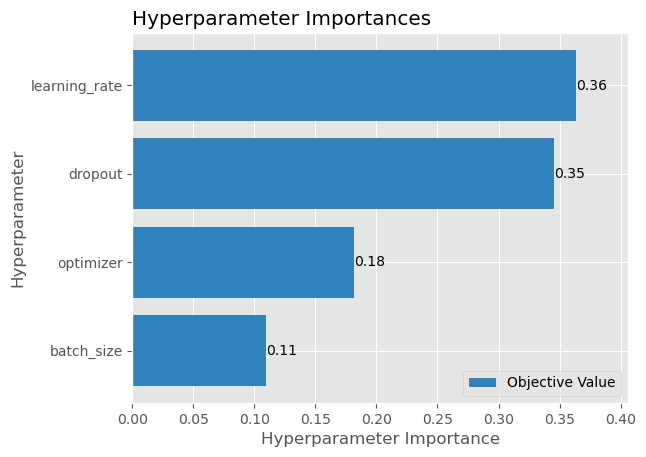

In [ ]:
# Visualize parameter importances.
plot_param_importances(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

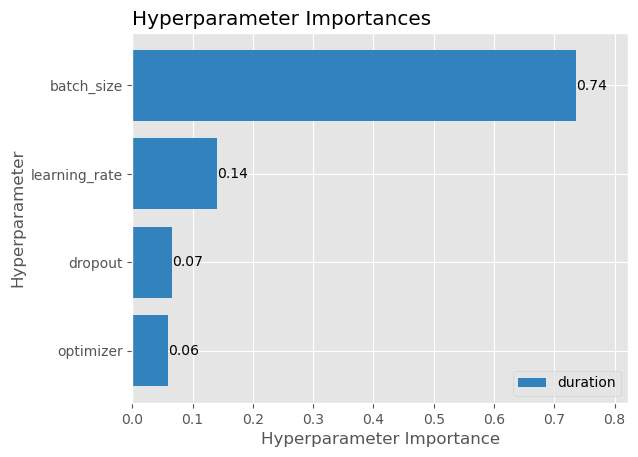

In [ ]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

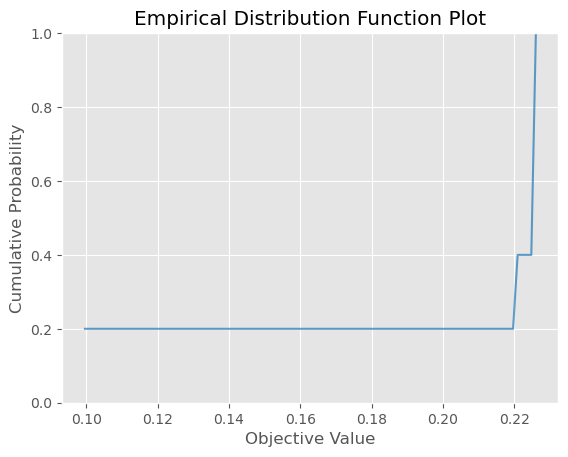

In [ ]:
# Visualize empirical distribution function.
plot_edf(study)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-05-22 12:37:05,052] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


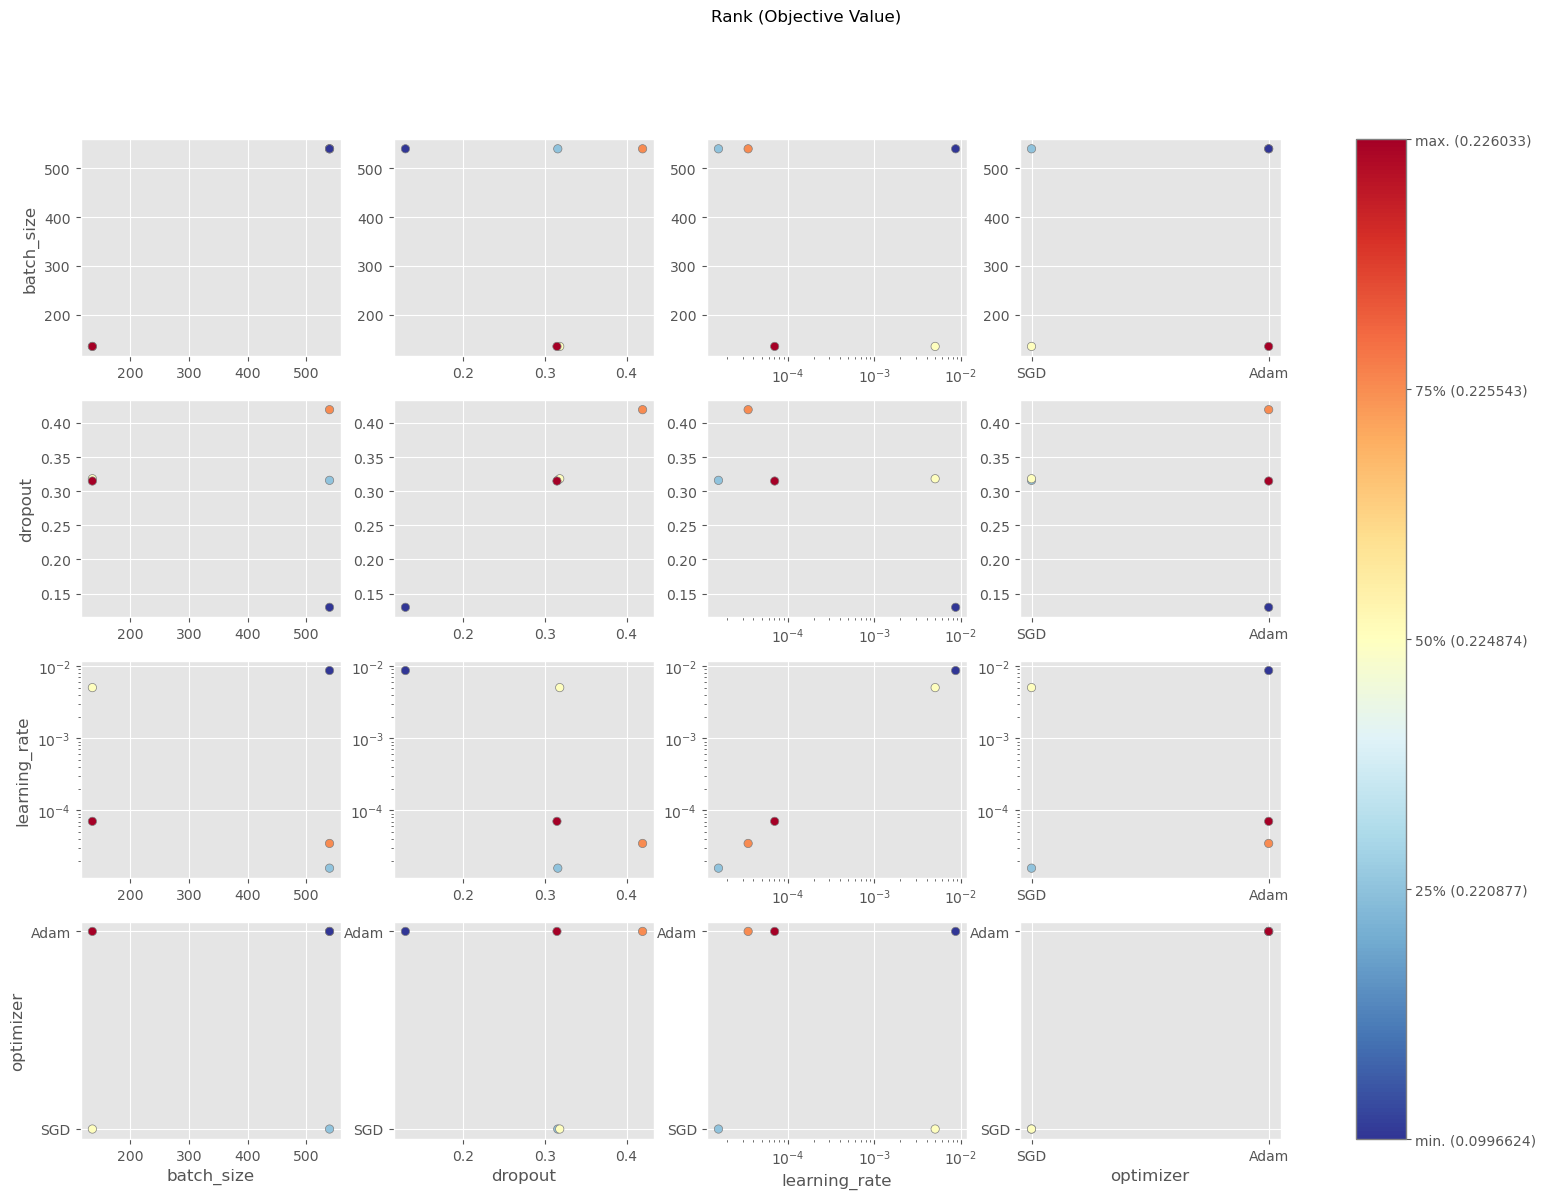

In [ ]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

C:\Users\tuur\AppData\Local\Temp\ipykernel_23076\124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


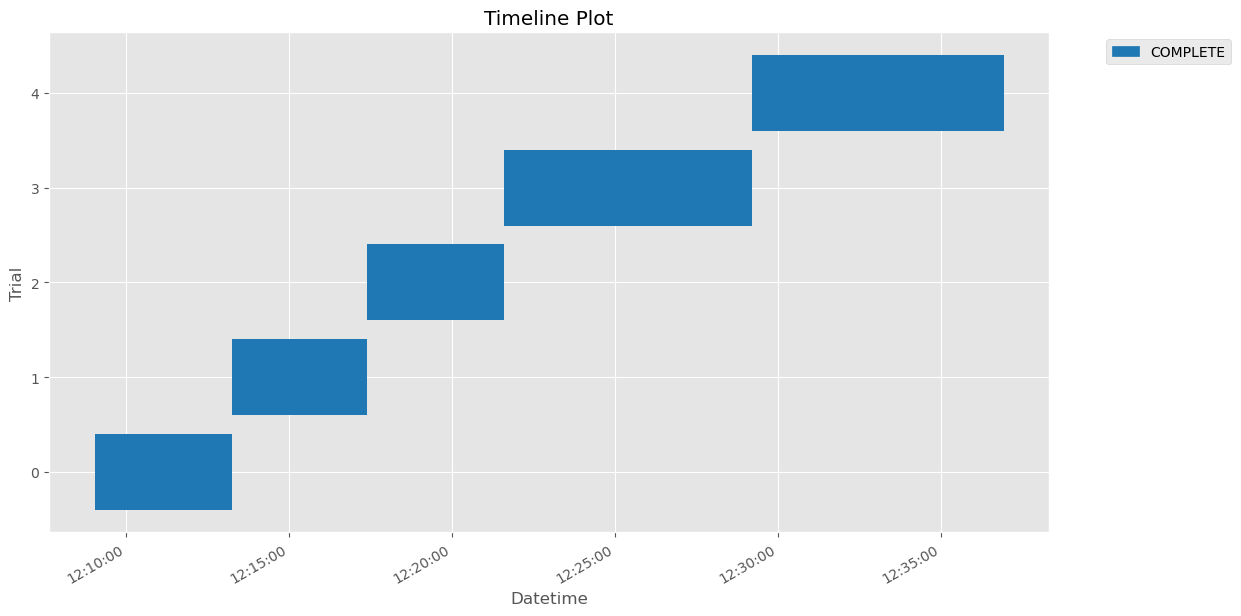

In [ ]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)